<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/quantum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum Computing**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_000.jpg)

In [ ]:
!pip install cirq --quiet
import cirq
import sympy
from cirq.contrib.svg import SVGCircuit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # %matplotlib inline
print(cirq.__version__)

### **<font color="blue">Physics $\vec \nabla^2$**

https://de.wikipedia.org/wiki/Kontinuitätsgleichung#Quantenmechanik

https://en.wikipedia.org/wiki/Variational_method_(quantum_mechanics)

https://en.wikipedia.org/wiki/Excited_state

###### **<font color="blue">Overview & Motivation**

https://en.m.wikipedia.org/wiki/Symmetry_(physics)

> Superconducting qubits are a design based on a **cooper pair**, which is just a pair of **electrons, or any other fermion**, which is a particle with a half-integer spin, combined with a **josephson junction**.


"*Quantum computers that use single electron spins in silicon QDs are seen as attractive due to their potential scalability and because silicon is already widely used in electronics technology.*"

https://www.sciencedaily.com/releases/2020/03/200302113310.htm

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1c/Standard_Model_of_Elementary_Particles-de.svg/502px-Standard_Model_of_Elementary_Particles-de.svg.png)

**Periodensystem**

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/Periodensystem_Einfach.svg/1024px-Periodensystem_Einfach.svg.png)

https://de.m.wikipedia.org/wiki/Periodensystem

https://de.m.wikipedia.org/wiki/Chemische_Reaktion

https://de.wikipedia.org/wiki/Zustand_(Quantenmechanik)#Phasenfaktor_und_Superposition

###### **<font color="blue">Bosons & Fermions**

**Fermionen**

* Fermionen (benannt nach Enrico Fermi) sind im physikalischen Sinne alle Teilchen, die der [Fermi-Dirac-Statistik](https://de.wikipedia.org/wiki/Fermi-Dirac-Statistik) genügen. Nach dem Spin-Statistik-Theorem besitzen sie einen **halbzahligen Spin**, also $\tfrac{1}{2}\hbar$, $\tfrac{3}{2}$ ℏ etc. 

* Anschaulich gesprochen sind Fermionen diejenigen Teilchen, aus denen die Materie besteht.

* Fermionen unterscheiden sich von den [Bosonen](https://de.wikipedia.org/wiki/Boson). Ein Elementarteilchen in drei Raumdimensionen ist immer entweder ein Fermion oder ein Boson.


* Zu den Fermionen gehören:

  * unter den Elementarteilchen: die **Leptonen** (z. B. das Elektron und das Neutrino) und die **Quarks** (alle – bis eventuell auf die Neutrinos – Dirac-Fermionen). ps: Quarks sind Bausteine von Protonen und Neutronen!

  * unter den zusammengesetzten Teilchen: unter anderem alle, die aus einer ungeraden Anzahl von Quarks aufgebaut sind, wie beispielsweise alle **Baryonen**, zu denen auch das Proton und das Neutron zählen, sowie die Pentaquarks.

* Von der mathematischen Theorie her sind drei Typen von Fermionen möglich:

  * Dirac-Fermionen: massiv, die „gewöhnlichen“ Fermionen

  * Weyl-Fermionen: masselos, hypothetisch bzw. als Quasiteilchen[1][2], siehe auch Weyl-Gleichung.

  * Majorana-Fermionen sind identisch mit ihren Antiteilchen (wie bei den Bosonen die Photonen) und daher auch elektrisch neutral, hypothetisch (eventuell die Neutrinos)

* Fermionen gehorchen dem [Pauli’schen Ausschlussprinzip](https://de.wikipedia.org/wiki/Pauli-Prinzip), 

  * welches besagt, dass zwei Fermionen nicht gleichzeitig an demselben Ort einen identischen Quantenzustand annehmen können. 

  * Allgemein gilt, dass die quantenmechanische Wellenfunktion zweier oder mehrerer gleichartiger Fermionen bei Vertauschung zweier Fermionen vollkommen [antisymmetrisch](https://de.wikipedia.org/wiki/Antisymmetrische_Funktion) sein muss, das heißt, das Vorzeichen ändert sich ([Phasenfaktor](https://de.wikipedia.org/wiki/Zustand_(Quantenmechanik)#Phasenfaktor_und_Superposition) −1).


**Boson**

* [Bosonen](https://de.wikipedia.org/wiki/Boson) sind alle Teilchen, die sich gemäß der **Bose-Einstein-Statistik** verhalten, in der u. a. mehrere ununterscheidbare Teilchen den gleichen Zustand einnehmen können. 

* haben sie einen **ganzzahligen Eigendrehimpuls (Spin)** in Einheiten des reduzierten Planckschen Wirkungsquantums ℏ. 

* Im Standardmodell der Teilchenphysik sind die **Austauschteilchen**, die die Kräfte zwischen den Fermionen vermitteln, elementare Bosonen mit einem Spin von 1, wie z. B. das Photon als Überträger der elektromagnetischen Kraft.

* Andere Bosonen sind aus mehreren Teilchen zusammengesetzt wie z. B. die **Cooper-Paare** aus Elektronen und Phononen als Ladungsträger im **Supraleiter**

**Statistiken**

* [Fermi-Dirac-Statistik](https://de.wikipedia.org/wiki/Fermi-Dirac-Statistik) beschreibt das makroskopische Verhalten eines Systems, das aus vielen gleichen Teilchen vom Typ Fermion besteht, und gilt z. B. für die Elektronen, die in Metallen und Halbleitern für die elektrische Leitfähigkeit sorgen.

* [Bose-Einstein-Verteilung](https://de.wikipedia.org/wiki/Bose-Einstein-Statistik): Sie beschreibt die mittlere Besetzungszahl $\langle n(E) \rangle$  eines Quantenzustands der Energie E im thermodynamischen Gleichgewicht bei der absoluten Temperatur T für identische Bosonen als besetzende Teilchen. 

* Beide gehen im Grenzfall großer Energie E in die [Boltzmann-Statistik](https://de.wikipedia.org/wiki/Boltzmann-Statistik) über


**We can write a single $\psi$ for the whole system of two or more particles, not only one**: 

(*from video: [Quantum Physics: BOSONS and FERMIONS Explained for Beginners](https://www.youtube.com/watch?v=skFU7pmBOys)*)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_123.png)

**but we have 2 different classes**:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_124.png)

Here examples of bosons and fermions (left). And right: For examples two electrons are indistinguishible, but if you swap their positions the wave function becomes negativ - **and it's not limited to 2 particle system, or 2 dimensional system**:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_125.png)

**A direct consequence from it is following:** Bose-Einstein-Condensate for Bosons and Pauli-Exclusion-Principle for Fermions

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_126.png)

###### **<font color="orange">Bose-Einstein-Condensate for Bosons and Pauli-Exclusion-Principle for Fermions**

Video: [Schroedinger Equation & Pauli Exclusion principle](https://www.youtube.com/watch?v=I93gZ_zfOpg)

Video: [The Basic Math that Explains Why Atoms are Arranged Like They Are: Pauli Exclusion Principle
](https://www.youtube.com/watch?v=INYZy6_HaQE&list=WL&index=20)

Video: [Bose-Einstein Condensate: The Quantum BASICS - Bosons and their Wave Functions](https://www.youtube.com/watch?v=lBpxQdikm0w&list=WL&index=21&t)

###### **<font color="orange">Dirac Equation**

Dirac-Equation beschreibt die Eigenschaften und das Verhalten eines fundamentalen Fermions mit Spin 1/2

Die [Dirac-Gleichung](https://de.wikipedia.org/wiki/Dirac-Gleichung) ist eine grundlegende Gleichung der relativistischen Quantenmechanik. Sie beschreibt die Eigenschaften und das Verhalten eines fundamentalen Fermions mit Spin 1/2 (zum Beispiel Elektron, Quark). Sie wurde 1928 von Paul Dirac entwickelt und erfüllt im Gegensatz zur Schrödingergleichung die Anforderungen der speziellen Relativitätstheorie.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_136.png)

###### **<font color="orange">Cooper-Paar & Josephson Junction**

Artikel: [Neuer Materiezustand im Supraleiter - Verbund aus vier Elektronen erzeugt zuvor unbekannten Aggregatzustand](https://www.scinexx.de/news/technik/neuer-materiezustand-im-supraleiter/)

* Überraschende Entdeckung: In einem Supraleiter haben Physiker einen zuvor unbekannten Materiezustand entdeckt.  Dabei entstanden Cluster aus jeweils vier gemeinsam agierenden Elektronen – normalerweise bilden sich beim Übergang zur Supraleitung nur Elektronenpaare.  Dieser „bosonische Metallzustand“ eröffnet ganz neue Einblicke in die physikalischen Mechanismen der Supraleitung und könnte neue Anwendungen hervorbringen, wie die Forscher im Fachmagazin „Nature Physics“ berichten.

* **In einem Supraleiter können sich Elektronen nahezu ohne Widerstand bewegen**. Gängiger Theorie nach liegt dies daran, dass die Elektronen im Kristallgerüst dieser Materialien bei ausreichend tiefen Temperaturen **einen Zustandswechsel durchlaufen**: Obwohl sie normalerweise Einzelgänger sind, **bilden sie nun sogenannte Cooper-Paare**. Diese reagieren wie eine Superflüssigkeit und **können sich ohne Reibungsverluste bewegen** – das Material wird supraleitend.






https://de.m.wikipedia.org/wiki/Josephson-Effekt

https://de.m.wikipedia.org/wiki/Tunnelstrom

https://de.m.wikipedia.org/wiki/Tunneleffekt

**Cooper-Paar**

* [Cooper-Paar](https://de.wikipedia.org/wiki/Cooper-Paar) – unter bestimmten Bedingungen können sich zwei Fermionen zu einem Boson zusammenschließen


**Josephson Junction (Josephson-Effekt)**

* https://de.wikipedia.org/wiki/Josephson-Effekt

###### **<font color="orange">Artificial atoms/ Synthetic elements**

https://www.sciencedaily.com/releases/2020/02/200211091815.htm

https://en.m.wikipedia.org/wiki/Synthetic_element

###### <font color="blue">**Ising Model**

https://www.youtube.com/watch?v=J-S_wUls314

> **The Ising Model represents the interactions of the spins of electrons in metals**.



* consider a two-dimensional square lattice

* has an electron on every vertex

* spins can only be orientated up or down

* depending on the configuration of the spins in the lattice the energy of the system will change 

* Goal: analyse dependence of temperature, energy and spin structure

* every electron only interacts with their nearest neighbors (in this case: 4). 

* this interaction will affect positively or negatively to the systems energy

**But why does it change? - Physicists use Hamiltonian to study the energy and behaviour of a system**

> $H=J \cdot \sum s_{i} s_{j}$

* H = Hamiltonian

* J = strenght of interaction

* $\sum$ = sum over all interactions

* $s_{i} s_{j}$ = spin interactions

**We can define the probability of having one spin configuration or other, depending on the system's temperature**:

> $p_{i}=\frac{e^{-\frac{H_{i}}{k T}}}{\sum e^{-\frac{H_{j}}{k T}}}$

* k = Boltzmann constant

* p = probability

* T = temperature

System tend to minimize the energy. This will happen in a way that it will have very different behaviors at low and high temperatures. Spins will align in clusters or not. 

* the system has two phases: disordered for hot temperatures and ordered for low temperatures

* between them the system will undergo a phase transition (occurs at a critical temperatures and has specular properties)

**What is the difference between these two phases?**

* first we can define the magnetization as the total angular momentum of all the spins $s_{up}$ = 1 and $s_{down}$ = -1.

> $m=N_{\mathrm{up}}-N_{\text {down }}$

* The total number of up and down spins will be our total magnetization: $s_{up}$ = 5 electrons and $s_{down}$ = 4 electrons:

> m = 5 - 4 = 1 = total magnetization

* disordered phase: m = 0, approx. same number of up and down spins

* ordered phase ≠ 0 $\rightarrow$ we can see how clusters emerge

* The point at which the system changes between phases, i.e. the critical temperature, is called the 'critical point'. 

> **The magnetization can be considered the order parameter since it determines whether we are in one phase or the other.**

Simulation on how the spins behave on every phase and its dependence on temperature:

* top: spins changes constantly orientation and on average same up and down spins, high entropy

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_172.png)

**Critical Temperature: What happens at the phase transition?**: Self-similarity / fractal behavior at differen scales!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_173.png)

* fundamental physics: consider smallest particles

* Ising model: consider different phases and phase transitions - cooperative phenomena. This is impossible to deduce by studying exclusively the bahvior of single particles

* we need to study **many body physics** and look for changes of the collective behavior using simple concepts as the **order parameter** focusing on the interrelation of the parts not only on the parts themselves.

* hence you dont need to solve Schroedinger equation a million times, which is why the ising model is so popular and the beauty of physics of **complex systems**

* Considering the nearest neighbors and focusing on the interaction of the parts started a new way of research: neural networks, social systems, ecosystems, protein folding etc.



---



https://www.youtube.com/watch?v=1CCZkHPrhzk

* [Das Ising-Model](https://de.wikipedia.org/wiki/Ising-Modell) ist ein Gittermodell in der theoretischen Physik. Es beschreibt insbesondere den Ferromagnetismus in Festkörpern (Kristallen). Das Ising-Modell zählt zu den meistuntersuchten Modellen der [statistischen Physik](https://de.wikipedia.org/wiki/Statistische_Physik).

* In dem Modell wird angenommen, dass die Spins, welche das magnetische Moment der Atome oder Ionen bestimmen, nur zwei diskrete Zustände annehmen können (Spinwert $\pm 1$). 

* Die Richtung im Raum bleibt aber offen; es handelt sich also um Vektoren (um im klassischen Bild zu bleiben, bzw. quantenmechanisch um Vektoroperatoren).

**Heisenberg-Modell**: Der allgemeine Energieausdruck (oder Hamiltonoperator) für eine solche Situation ist durch das [Heisenberg-Modell](https://de.wikipedia.org/wiki/Heisenberg-Modell) gegeben:

> $\hat{\mathcal{H}}=-\frac{1}{2} \sum_{i, j} J_{i j} \vec{s}_{i} \cdot \vec{s}_{j}-\vec{H} \cdot \sum_{i=1}^{N} \vec{s}_{i} \quad(\text { Heisenberg-Modell })
$

Hierbei bezeichnet
- $\vec{s}_{i}$ einen (mehrkomponentigen) Spin des Atoms am Platz $i$ des Kristallgitters,
- $J_{i j}$ die Kopplungskonstante (Stärke der Austauschkopplungs-Wechselwirkung) zwischen den Spins an den Plätzen $i$ und $j$,
- der Punkt \cdot das Skalarprodukt
- $\vec{H}$ die Stärke des Magnetfeldes.

Beim **Ising-Modell** dagegen wird die Zahl der Spinkomponenten auf Eins reduziert (d.h. parallel oder antiparallel zu einer ausgezeichneten Achse - hier $z$-Achse): $s_{i}^{z}=\pm 1$ :

>$
\hat{\mathcal{H}}=-\frac{1}{2} \sum_{i, j} J_{i j} s_{i}^{z} s_{j}^{z}-H_{z} \sum_{i=1}^{N} s_{i}^{z} \quad(\text { Isingmodell })
$

Oft wird zusätzlich angenommen, dass $J_{ij}$ nur für benachbarte Spins ungleich Null ist. Ist die Austauschkopplung positiv, so spricht man von einer ferromagnetischen Kopplung; ist sie negativ, so wird sie antiferromagnetisch genannt. Bei Ferromagneten bzw. Antiferromagneten dominiert das jeweilige Vorzeichen; bei den Spingläsern kommen beide Vorzeichen gleich häufig vor.

* Durch geeignete Wahl der Wechselwirkungen können u. a. Spingläser (hierbei ist $J_{ij}$ eine Zufallsgröße), verdünnte Magnete mit interessanten kritischen Eigenschaften oder auch räumlich modulierte magnetische Strukturen (hierbei liegen konkurrierende Kopplungen $J_{ij}$ vor, siehe [ANNNI-Modell](https://de.wikipedia.org/wiki/ANNNI-Modell)) modelliert werden. 

* Im Allgemeinen beschreibt das Ising-Modell die magnetischen Ordnungen bei tiefen Temperaturen, die bei höheren Temperaturen jedoch durch thermische Fluktuationen aufgebrochen werden, wobei ein Phasenübergang stattfindet. Eine umfassende theoretische Analyse von Phasenübergängen liefert die Theorie der [Renormierungsgruppen](https://de.wikipedia.org/wiki/Renormierungsgruppe), für die Kenneth G. Wilson 1982 den Nobelpreis für Physik erhielt.

Bei der eindimensionalen Ising-Kette mit hinreichend kurzreichweitigen Wechselwirkungen beobachtet man jedoch keinen Phasenübergang. Dies hatte schon Ernst Ising in seiner Doktorarbeit mit Bedauern feststellen müssen. Fälschlicherweise vermutete er, dass dies auch für zwei und mehr Dimensionen zutrifft, was zunächst allgemein akzeptiert wurde.

Rudolf Peierls zeigte jedoch 1936,[4] dass in zwei Dimensionen sehr wohl ein Phasenübergang vorlag. 1941 bestimmten Hendrik Anthony Kramers und Gregory Wannier[5] durch ein Dualitätsargument die kritische Temperatur. Die exakte Lösung des zweidimensionalen Ising-Modells mit Wechselwirkungen zwischen nächsten Nachbarn und bei verschwindendem Magnetfeld wurde erstmals 1944 von Lars Onsager berechnet.

**Solutions**

* Für das dreidimensionale Ising-Modell mit Wechselwirkungen zwischen benachbarten Spins gibt es keine analytisch-exakte Lösung. Seine Eigenschaften kann man jedoch mit Hilfe der Molekularfeldnäherung (oder Landau-Theorie), Monte-Carlo-Simulationen, Reihenentwicklungen oder anderen numerischen Lösungsverfahren berechnen.

* Das Ising-Modell gilt wegen seiner konzeptionellen Einfachheit und seiner vielfältigen Eigenschaften als „Drosophila“ der statistischen Physik. Es hat darüber hinaus Anwendungen in vielen Bereichen der Naturwissenschaften gefunden, bis hin zur Biologie und Hirnforschung. Die nahezu programmatische Aussage von Michael E. Fisher ‚Ising models still thrive‘ (etwa: ‚Ising-Modelle sind noch im Wachsen‘) wird wohl noch für viele Jahre gültig bleiben.

* Verallgemeinerungen des Ising-Modells liefern das Blume-Capel-Modell, das Potts-Modell und das Markow-Netzwerk.

https://de.m.wikipedia.org/wiki/Ising-Modell

https://www.quantamagazine.org/the-cartoon-picture-of-magnets-that-has-transformed-science-20200624/

### <font color="blue">**Spin**

###### **<font color="blue">Spin of a particle I: Physics (Spin-Orbit-Coupling & Fine Structure)**


Single spin one half particle, focus on spin degrees of freedom: 

* when the spin degrees of freedom interact with an electromagnetic field, the Pauli matrices come into play:

> $\sigma^{Z}=\left(\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right) \quad \sigma^{X}=\left(\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right) \quad \sigma^{Y}=\left(\begin{array}{cc}0 & -i \\ i & 0\end{array}\right)$

* we have chosen a basis in such a way that the Pauli Z matrix is diagonal. Here are its basis vectors, the spin up in the z direction and the spin down direction, written as column vectors:

> $|\uparrow\rangle=\left(\begin{array}{l}1 \\ 0\end{array}\right) \quad 1 \downarrow=\left(\begin{array}{l}0 \\ 1\end{array}\right)$

* we can re-express the basis vectors for the Pauli X matrix in either direction in terms of these vectors, but in the positive direction we can write it in the following way:

> $|\rightarrow\rangle=\frac{1}{\sqrt{2}}(|\uparrow\rangle+|\downarrow\rangle)$

**The effect of a spin on an atom: Spin-Orbit-Coupling (Fine Structure)**

*from Video: [How the Spin of an Electron Affects the Atom It's In - Spin-Orbit Coupling (Fine Structure): Parth G](https://www.youtube.com/watch?v=Odgg-IXwkwI)*

> At the center of an atom we find the nucleus, that contains protons and neutrons.

* electrons are found in very specific energy levels surrounding the nucleus, they are **called "shells"**

* and electrons in these shells have angular momentum, similar to "linear momentum" (we only call momentum: mass multiplied by velocity)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_127.png)

**Even if the electron is not moving along a curve, it still has some angular momentum: "Spin" !!** 

Things get interesting when charged particles have some inherent angular momentum (with charges of -1.6 x 10<sup>-19</sup> C for coloumbs! 

Spin / inherent angular momentum can interact with magnetic fields:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_128.png)

<font color="blue">**Spin comes from "special relativistic effects in quantum mechanics"**. **Spin can be measured in two states: up or down**, Which means it can show the behavior of spinning clockwise of anti-clockwise.

> Check [Stern-Gerlach-experiment](https://de.wikipedia.org/wiki/Stern-Gerlach-Versuch) to understand how to measure spin

> Check [Dirac-Equation](https://de.wikipedia.org/wiki/Dirac-Gleichung) : beschreibt die Eigenschaften und das Verhalten eines fundamentalen Fermions mit Spin 1/2

*Video: [Spin in Quantum Mechanics: What Is It and Why Are Electrons Spin 1/2? Physics Basics](https://www.youtube.com/watch?v=DCrvanB2UWA)*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_136.png)

<font color="blue">**Spin is quantized ! But not all particles are in the same quantized (not all show same possible spin measurement 2 spin up/down states)** 

<font color="blue">Photons have 3 different spin states etc. 

* And spin can only be an integer, or an half of something. 

* = refers to  the magnitude of size of the maximum angular momentum that a particle can have when we take that number and multiply it by $\hbar$ (reduced Planck constant).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_137.png)

<font color="blue">Spin angular momentum of one half multiplied by $\hbar$. **But we can also use this number to figure out how many possible spin states our particle can have**: 

* take a spin half particle like an electron, and we already know the angular momentum it can have in one possible state (=1/2 $\hbar$. 

* Then subtract 1 = gives us the angular momentum our particle can have in another possible state, here minus 1/2 $\hbar$ (same size, but pointing / spinnign in another direction)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_138.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_139.png)

<font color="blue">One more calculation for another spin number. And then: **all particles with half integer spin display very different behaviors to all particles with integer spin !**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_140.png)

These spinning charges behave like little magnets and they have a property known as the **"magnetic diopole moment"**

* is a vector quantity that measures size and direction of this little magnet created by the spinning charge

* and when another magnetic field is found in the region of space in which our particle happens to be, then the magnetic diopole moment of the charged particle interacts with the magnetic field

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_129.png)

From the reference frame of an electron in the atom, the electron experiences a magnetic field. 

But if we look at an atom from the nucleus' perspective (what we commonly do) there isn't a magnetic field. All we have is an electric field created by the electric charges

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_130.png)

This has to do with the idea that electric and magnetic fields look different from different perspectives

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_131.png)

> <font color="red">**The interaction between the external magnetic field and the magnetic dipole moment of a particular electron is proportional to the dot product between these two.**</font>

* This interaction which specifically affects the energy of the electron is proportional to what's also know as the scalar product between mu and B. 

* Then we can take the interaction term (that describes an energy change of an electron in this case) and rewrite in to the new terms $L$ (=orbital angular momentum = when an electron is in a particular shell around the nucleus) and $S$ (=spin)

> <font color="red">**IMPORTANT: So the energy of an electron in a particular atom isn't just related to what shell it's in. It also depends on this interaction between orbital angular momentum and spin angular momentum.**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_133.png)

**Reminder Dot Product:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_132.png)

**Shells and subshells:** 

* the difference between the subshells is the different orbital angular momentum an electron will have. 

* Each subshell has it's own L-value !!

* And hence the energy of each particle in a given subshell will be different to the energy in other subshells. And different subshells can exist within the same shell. These shells are split energy levels.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_134.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_135.png)

###### **<font color="blue">Spin of a particle II: Mathematics (Dirac Belt, Spin ½ Explanation, SU(2) + SO(3))**

**SU(2) als Spin-Gruppe**

* See video [Dirac's Belt trick](https://www.youtube.com/watch?v=ACZC_XEyg9U&t=2969s)

* [SO(3)](https://de.wikipedia.org/wiki/Drehgruppe): Elemente sind die Drehmatrizen, also orthogonale Matrizen mit Determinante eins

* [SU(2)](https://de.wikipedia.org/wiki/SU(2)): die spezielle unitäre Gruppe der Ordnung 2, d. h. die lineare Gruppe der unitären 
(
2
×
2
)-Matrizen mit Determinante 1

* **$\mathrm{SU}(2)$ ist eine 2 -fache Überlagerung der Drehgruppe $\mathrm{SO}(3)$**, sie realisiert also die Spin-Gruppe Spin (3). 

  * Die natürliche Operation von $\mathrm{SU}(2)$ auf $\mathbb{C}^{2}$ ist eine sog. Spinordarstellung.

  * Explizit wird die Überlagerung gegeben durch die adjungierte Darstellung von $\mathrm{SU}(2)$ auf ihrer 3-dimensionalen Lie-Algebra $\mathfrak{s u}(2)$. Diese lässt die Killing-Form $B$ und damit auch $-B$ invariant. Weil $-B$ positiv definit ist, ist die Gruppe der $-B$ erhaltenden linearen Abbildungen isomorph zu $O(3)$. 
  
  * Man kann zeigen, dass die so definierte Abbildung eine 2-fache Überlagerung $\mathrm{SU}(2) \rightarrow \mathrm{SO}(3)$ definiert.

* Siehe auch: https://de.wikipedia.org/wiki/Drehimpuls_(Quantenmechanik)#Drehimpulsoperatoren_und_die_Drehgruppe

*SO(3) is a 2-sphere, meanwhile SU(2) is a 3-sphere. 3-sphere can be depicted as two solid balls glued together along their boundary:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_121.png)

*SO(3) x 2 describes what happens on the 4 dimensional SU(2)*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_120.png)

*Topologically: the covering space is 2x the base space*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_119.png)

**Spin of a particle: More theory**


https://en.wikipedia.org/wiki/Spin_quantum_number

Siehe auch: https://de.wikipedia.org/wiki/Pauli-Matrizen#Zugeordnete_Drehgruppe,_Zusammenhang_mit_Spin-1/2-Systemen

> A single spin-1/2 state, or "qubit", is represented as a normalized state $\left(\begin{array}{l}a \\ b\end{array}\right)$ where $|\mathrm{a}|^2+|\mathrm{b}|^2=1 .$ The phase of this is irrelevant, so you can always multiply both "a" and "b" by exp(ic) without changing the state. Note that this formalism can be used for any $2 \mathrm{D}$ Hilbert space state; it doesn't *have* to be a spin-1/2 particle.

**Spin (Drehimpuls)**

* [Spin](https://de.wikipedia.org/wiki/Spin) (von englisch spin ‚Drehung‘, ‚Drall‘) ist in der Teilchenphysik der [Eigendrehimpuls](https://de.wikipedia.org/wiki/Drehimpuls) von Teilchen. 

  * [(Eigen)Drehimpuls](https://de.wikipedia.org/wiki/Drehimpuls) ist eine vektorielle Größe, und zwar – wie das Drehmoment und die Winkelgeschwindigkeit – ein Pseudovektor. Seine Dimension ist das Produkt aus Masse, Länge und Geschwindigkeit.

* Bei den fundamentalen Teilchen ist er wie die Masse eine unveränderliche innere Teilcheneigenschaft. 

> **Der Spin beträgt ein halb- oder ganzzahliges Vielfaches (Spinquantenzahl) des reduzierten planckschen Wirkungsquantums ℏ.**

* **Der Spin kann nur quantenmechanisch verstanden werden**. Er wird nicht durch die (Dreh-)Bewegung einer Masse hervorgerufen. 

* Das [Spin-Statistik-Theorem](https://de.wikipedia.org/wiki/Spin-Statistik-Theorem) verbindet den Spin eines Teilchens mit der Art der statistischen Beschreibung mehrerer gleicher Teilchen: 

  * Teilchen mit einer halbzahligen Spinquantenzahl befolgen die Fermi-Dirac-Statistik und heißen Fermionen, 
  
  * Teilchen mit einer ganzzahligen Spinquantenzahl befolgen die Bose-Einstein-Statistik und heißen Bosonen.

* Bei zusammengesetzten Systemen, z. B. bei Proton, Neutron, Atomkern, Atom, Molekül, Exziton, Hadronen wie [$\Omega ^{-}$-Teilchen](https://de.wikipedia.org/wiki/Ω-Baryon) ergibt sich der Spin durch Addition der Spins und Bahndrehimpulse der Komponenten nach den Regeln der quantenmechanischen Drehimpulsaddition.

* **Der halbzahlige Spin kann weder anschaulich noch halbklassisch durch eine Drehbewegung erklärt werden.**

$
\begin{array}{|c|c|l|}
\hline \text { Spin } & \text { Typ } & {\text { Teilchen (Beispiele) }} \\
\hline 0 & \text { Boson } & \text { Higgs-Boson } \\
\hline \frac{1}{2} \hbar & \text { Fermion } & \text { Elektron, Neutrino, Quarks } \\
\hline 1 \hbar & \text { Boson } & \text { Photon, Gluon, W-Boson und Z-Boson } \\
\hline \frac{3}{2} \hbar & \text { Fermion } & \text { supersymmetrische Teilchen (hypothetisch) } \\
\hline 2 \hbar & \text { Boson } & \text { Graviton (hypothetisch) } \\
\hline
\end{array}
$

*Spin ist ein [Pseudovektor](https://de.wikipedia.org/wiki/Pseudovektor): Der Drehimpuls L als Beispiel eines Pseudovektors: während der Ortsvektor r und Impuls m·v bei einer Punktspiegelung ihre Richtung umkehren, bleibt die des Drehimpulses L=m·r×v unverändert:*

![gg](https://upload.wikimedia.org/wikipedia/commons/a/af/Angular_momentum_as_pseudo-vector.png)

**Spin ½ als Äquivalent aller 2-Zustands-Systeme**

> Mathematischer Hintergrund dieser Äquivalenz ist die Tatsache, dass die Basistransformationen im zweidimensionalen komplexen Hilbertraum eine Darstellung der [Gruppe SU(2)](https://de.wikipedia.org/wiki/SU(2)) bilden, die „doppelt so groß ist“ wie die Gruppe [SO(3)](https://de.wikipedia.org/wiki/Drehgruppe) der Drehungen im reellen dreidimensionalen Raum. 

* Der Unterschied zu den „normalen“ Drehungen im dreidimensionalen Raum liegt darin, dass die vom Spinoperator erzeugte Drehung mit dem Drehwinkel 360° nicht durch die Einheitsmatrix 1 wiedergegeben wird, sondern durch -1. 

* Dabei geht der physikalische Zustand zwar in sich selber über, der Zustandsvektor aber in sein Negatives. Das eine ist mit dem anderen verträglich, weil Zustandsvektoren, die sich nur um einen komplexen Faktor unterscheiden, denselben Zustand beschreiben. **Erst eine 720°-Drehung bringt wieder denselben Zustandsvektor hervor**.

**English: Spin ½**

* The spin number describes how many symmetrical facets a particle has in one full rotation; a spin of 1/2 means **that the particle must be rotated by two full turns (through 720°) before it has the same configuration as when it started**.

* Particles having net spin ½ include the proton, neutron, electron, neutrino, and quarks. The dynamics of spin-½ objects cannot be accurately described using classical physics; they are among the simplest systems which require quantum mechanics to describe them. As such, the study of the behavior of spin-½ systems forms a central part of quantum mechanics.

* A spin- $\frac{1}{2}$ particle is characterized by an [angular momentum bzw. azimuthal quantum number](https://en.m.wikipedia.org/wiki/Azimuthal_quantum_number) for spin s of $\frac{1}{2}$. In solutions of the Schrödinger equation, angular momentum is quantized according to this number, so that total spin angular momentum
$
S=\sqrt{\frac{1}{2}\left(\frac{1}{2}+1\right)} \hbar=\frac{\sqrt{3}}{2} \hbar
$

*Illustration of quantum mechanical orbital angular momentum:* [Source](https://en.m.wikipedia.org/wiki/Azimuthal_quantum_number)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/Vector_model_of_orbital_angular_momentum.svg/421px-Vector_model_of_orbital_angular_momentum.svg.png)

*Heuristic depiction of spin angular momentum cones for a spin-½ particle:* [Source](https://en.m.wikipedia.org/wiki/Spin-1/2)
 
 ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b3/Spin_half_angular_momentum.svg/624px-Spin_half_angular_momentum.svg.png)

*Vector cones of total angular momentum J (purple), orbital L (blue), and spin S (green). The cones arise due to quantum uncertainty between measuring angular momentum components:*  [Source](https://en.m.wikipedia.org/wiki/Angular_momentum_operator)

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/LS_coupling.svg/449px-LS_coupling.svg.png)

*The atomic orbital wavefunctions of a hydrogen atom. The principal quantum number (n) is at the right of each row and the azimuthal quantum number (ℓ) is denoted by letter at top of each column:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/c/cf/HAtomOrbitals.png)

### <font color="blue">**Atomic Orbital**

https://en.m.wikipedia.org/wiki/Atomic_orbital

###### **<font color="blue">Quantum Numbers & "Vollständiger Satz kommutierender Observablen"**

Speed vs Velocity: velocity includes direction, so speed can be 1, velocity -1 if we change direction.

Four quantum numbers in atomic physics. The set is: principal quantum number, azimuthal quantum number, magnetic quantum number, and spin quantum number. Together, they describe the unique quantum state of an electron. 

Video: [Why Real Atoms Don't Look Like This - Quantum Numbers to Understand Atomic Structure](https://youtu.be/EhIbCrl1pGw)

* [Quantum Numbers](https://de.wikipedia.org/wiki/Quantenzahl) are used to describe certain quantitites that we are allowed to know at the same time as knowing the energy of a quantum system. **They together completely describe the quantum state of an electron in an atom**!

  * **$n$: principal quantum number**. which shell, $n_1$ with lowest energy.

  * **$L$: azimuthal quantum number**.  which subshell? is a quantum number for an atomic orbital that determines its orbital angular momentum and describes the shape of the orbital

  * **$m_l$ magnetic quantum numbers**, distinguishes the orbitals available within a subshell, and is used to calculate the azimuthal component of the orientation of orbital in space.
  
  * **$m_s$ spin quantum number**, describes the intrinsic angular momentum (or spin angular momentum, or simply spin) of an electron or other particle (The name comes from a physical spinning of the electron about an axis, as proposed by Uhlenbeck and Goudsmit). The value of $m_s$ is the component of spin angular momentum parallel to a given direction (the z–axis), which can be either +1/2 or –1/2 (in units of the reduced Planck constant).

* Heisenberg uncertainty principle: things we are not allowed to know at the same time, like position and momentum of a particle

Siehe auch: ["Vollständiger Satz kommutierender Observablen"](https://de.wikipedia.org/wiki/Vollständiger_Satz_kommutierender_Observablen)

* Begriff aus der Quantenmechanik, in der Messgrößen wie Energie, Ort oder Impuls durch Operatoren dargestellt und als Observablen bezeichnet werden. 

* Messgrößen, die man gleichzeitig genau bestimmen kann, heißen kommutierende Observablen; sie haben die Eigenschaft, dass ihre Operatoren miteinander vertauschen.

* Solch ein Verhalten ist in der Quantenmechanik allerdings eher die Ausnahme. Die meisten Paare von Observablen lassen sich nicht gleichzeitig beliebig genau messen, was eine Konsequenz aus der heisenbergschen Unschärferelation ist. Man spricht dann auch von komplementären Observablen.

> **Um einen quantenmechanischen Zustand eindeutig zu charakterisieren, sind oft mehrere Observablen notwendig**. Beispielsweise ist es beim Wasserstoffatom nicht ausreichend, nur die Energie anzugeben (mittels der Hauptquantenzahl n), sondern es sind zwei weitere Observablen notwendig: der Betrag des Drehimpulses (Quantenzahl l) und die z-Komponente des Drehimpuls (Quantenzahl m). Diese drei Größen bilden dann einen vollständigen Satz kommutierender Observablen.

Eine Menge von Observablen A, B, C,... bildet einen v.S.k.O., wenn eine **orthonormale Basis des Zustandsraums aus gemeinsamen Eigenvektoren** der Observablen existiert, und diese Basis (bis auf einen Phasenfaktor) eindeutig ist.

Eine äquivalente Formulierung lautet: Eine Menge von Observablen A, B, C,... bildet einen v.S.k.O. genau dann, wenn:

* alle Observablen paarweise miteinander vertauschen, und

* **die Angabe der Eigenwerte aller dieser Operatoren ausreicht, um (bis auf einen Faktor) eindeutig einen gemeinsamen Eigenvektor zu bestimmen**.

Um ein quantenmechanisches Problem zu lösen, ist man bemüht eine Menge von Observablen zu finden, die das System beschreiben und einen v.S.k.O. bilden. 

* **Durch die Angabe der Messwerte der Observablen (das sind die Eigenwerte der Observablen**) ist es damit möglich den Zustand eines Systems eindeutig zu bestimmen. 

* Umgekehrt bedeutet das, dass man eine Messung auf einen vollständigen Satz kommutierender Observablen erstrecken muss, um den Zustand des Systems nach der Messung durch die Angabe der Messwerte eindeutig zu bestimmen.


###### **<font color="blue">Principle quantum number (n): Total Energy (?)**

> Corresponds to Bohr's orbit numbers

> Different orbitals (azimuthal quantum numbers) are allowed for each n principal quantum number:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_197.png)


**Diagram of the S and P orbitals**: *The s subshells are shaped like spheres. Both the 1n and 2n principal shells have an s orbital, but the size of the sphere is larger in the 2n orbital. Each sphere is a single orbital. p subshells are made up of three dumbbell-shaped orbitals. Principal shell 2n has a p subshell, but shell 1 does not.*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_180.jpeg)

https://courses.lumenlearning.com/boundless-chemistry/chapter/orbital-shapes/

**Principle quantum number (n): which electron shell we are talking about. $n_1$ is lowest in energy:**

* In quantum mechanics, the [principal quantum number](https://en.wikipedia.org/wiki/Principal_quantum_number) (symbolized n) is one of four quantum numbers assigned to each electron in an atom to describe that electron's state. Its values are natural numbers (from 1) making it a discrete variable.

* In chemistry, values n = 1, 2, 3, 4, 5, 6, 7 are used in relation to the [electron shell theory](https://en.wikipedia.org/wiki/Electron_shell), with expected inclusion of n = 8 (and possibly 9) for yet-undiscovered period 8 elements. In atomic physics, higher n sometimes occur for description of excited states. Observations of the interstellar medium reveal atomic hydrogen spectral lines involving n on order of hundreds; values up to 766 were detected.



![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_141.png)

###### **<font color="blue">Azimuthal quantum number (L): Sub Shells**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_196.png)

---- there is yet another one: f-type, and it comes in sets of 7. ony allowed in n principal quantum number = 4

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_197.png)


https://www.youtube.com/watch?v=ysQfZ48B7rg

**Azimuthal quantum number (L): sub shells. Main electron shells are most likely distances from the nucleus, not definite positions (represented by wave function), here for n1 and n2:**

* The [azimuthal quantum number](https://en.wikipedia.org/wiki/Azimuthal_quantum_number) is a quantum number for an atomic orbital that determines its [orbital angular momentum](https://en.wikipedia.org/wiki/Angular_momentum_operator) and describes the shape of the orbital.  $\mathbf {L} =\left(L_{x},L_{y},L_{z}\right)$

* Be careful: difference to: There is another type of angular momentum, called [spin angular momentum (short: spin)](https://en.wikipedia.org/wiki/Spin_(physics)), represented by the spin operator $\mathbf {S} =\left(S_{x},S_{y},S_{z}\right)$. 

* [edit]
Finally, there is total angular momentum $\mathbf {J} =\left(J_{x},J_{y},J_{z}\right)$, which combines both the spin and orbital angular momentum of a particle or system: $\mathbf {J} =\mathbf {L} +\mathbf {S}$.

*Vector cones of total angular momentum J (purple), orbital L (blue), and spin S (green). The cones arise due to quantum uncertainty between measuring angular momentum components*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/LS_coupling.svg/449px-LS_coupling.svg.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_142.png)

* 3 individual orbitals, each made up of three individual orbitals of which is shaped like dumbbell. 

* Each of the dumbbell os perpendicular to each other: one lies along the x-axis, another along y-axis and one on z-axis. 

* each of these dumbbell-shaped orbitals can hold 2 electrons. Looking at x-axis: electron can be found at different places,  but most likely to be found somewhere in the dumbbell-shape (it's now orientated)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_143.png)

So there is a difference now between spherical sub shell and the the triple dumbbell sub shell

> **the energy level dictates how many sub shells there are for electrons to fill**

* n=1 energy level has only one sub shell, the spherical one

* n=2 energy level has two sub shells: the spherical one and the triple dumbbell one,

* n=3 energy level has three different sub shells

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_144.png)

> **What's the difference between the spherical sub shell and the triple dumbbell sub shell?** other than the shape?

* electrons within a particular sub shell have different amounts of orbital angular momentum ! (Not meant: spin, because that's independent of subshell position)

> **We can represent how much angular momentum an electron has in a particular sub shell using the azimuthal quantum number.**

* any electron in any one of the spherical shaped orbitals known as s-orbitals has no angular momentum at all. -> we give each s-orbtial the azimuthal quantum number L=0. here three examples: 

  * for an electron in the lowest possible energy level n=1 it must be in the s-subshell (because there is only the sub shell) with azimuthal quantum number L=0

  * for an electron in the second shell and the s-subshell it has the quantum numbers n=2 and l=0

  * but for an electron on the p-subshell it does have a certain amount of angular momentum. Specifically it has 1 lot of h bar of angular momentum and n=2 and l=1

  * for n=3 energy levels (not depicted below) then we could have electrons in the s-subshell with l=0, or p-subshell with l=1 or the d-subshell with l=2 !

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_145.png)

###### **<font color="blue">Magnetic quantum number $m_l$**

**And then there are two more quantum numbers: $m_l, m_s$**

[Magnetic quantum number](https://en.wikipedia.org/wiki/Magnetic_quantum_number): the magnetic quantum number distinguishes the orbitals available within a subshell, and is used to calculate the azimuthal component of the orientation of orbital in space. 

  * Electrons in a particular subshell (such as s, p, d, or f) are defined by values of ℓ (0, 1, 2, or 3). 
  
  * The value of ml can range from -ℓ to +ℓ, including zero. Thus the s, p, d, and f subshells contain 1, 3, 5, and 7 orbitals each, with values of m within the ranges 0, ±1, ±2, ±3 respectively.
  
  * Each of these orbitals can accommodate up to two electrons (with opposite spins), forming the basis of the periodic table.

*These orbitals have magnetic quantum numbers $m=-\ell ,\ldots ,\ell$ from left to right in ascending order. The $e^{mi\phi }$ dependence of the azimuthal component can be seen as a color gradient repeating m times around the vertical axis:*
![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/Atomic_orbitals_spdf_m-eigenstates.png/640px-Atomic_orbitals_spdf_m-eigenstates.png)

###### **<font color="blue">Spin quantum number $m_s$**

[Spin quantum number](https://en.wikipedia.org/wiki/Spin_quantum_number): In atomic physics, the spin quantum number is a quantum number (designated ms) which describes the intrinsic angular momentum (or spin angular momentum, or simply spin) of an electron or other particle. 

  * The phrase was originally used to describe the fourth of a set of quantum numbers (the principal quantum number n, the azimuthal quantum number l, the magnetic quantum number m, and the spin quantum number ms), which completely describe the quantum state of an electron in an atom. 
  
  * The name comes from a physical spinning of the electron about an axis, as proposed by Uhlenbeck and Goudsmit. 
  
  * **The value of $m_s$ is the component of spin angular momentum parallel to a given direction (the z–axis)**, which can be either +1/2 or –1/2 (in units of the reduced Planck constant).

  * At an elementary level, ms is described as the spin quantum number, and s is not mentioned since its value 1/2 is a fixed property of the electron. **At a more advanced level where quantum mechanical operators are introduced, s is referred to as the spin quantum number, and $m_s$ is described as the spin magnetic quantum number or as the z-component of spin $s_z$.**



![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_146.png)

### **<font color="blue">Wasserstoffproblem $H_2$**

###### <font color="blue">**Quantum Numbers: Hydrogen Electron Orbitals**


> Die einfachste Schrödinger-Gleichung für ein geladenes Teilchen im Coulombfeld einer Punktladung wird als Wasserstoffproblem bezeichnet. 

**Beispiel: Verschiedene Orbitale des Wasserstoffs mit m=0** 

> **The energy level dictates how many sub shells there are for electrons to fill**

* n=1 energy level (principal quantum number) has only one sub shell s (azimuthal quantum number), the spherical one (=no orbital angular momentum)

* n=2 energy level (principal quantum number) has two sub shells s und p (azimuthal quantum number): the spherical one and the triple dumbbell one,

* n=3 energy level (principal quantum number) has three different sub shells s, p und d (azimuthal quantum number)

**Example: The atomic orbital wavefunctions of a hydrogen atom. The principal quantum number (n) is at the right of each row and the azimuthal quantum number (ℓ) is denoted by letter at top of each column)**

* *The principal quantum number (n) is at the right of each row (which electron shell we are talking about.  $n_1$  is lowest in energy)*,

* *the azimuthal quantum number (ℓ) is denoted by letter at top of each column (which subshell)*

![gg](https://upload.wikimedia.org/wikipedia/commons/c/cf/HAtomOrbitals.png)

<font color="red">**IMPORTANT: The energy of an electron in a particular atom isn't just related to what shell it's in. It also depends on this interaction between orbital angular momentum and spin angular momentum.**

**Quantum Numbers in Hydrogen Atom**

* The angular momentum quantum number ℓ = 0, 1, 2, ... determines the magnitude of the angular momentum.

* This leads to a third quantum number, the principal quantum number n = 1, 2, 3, ....

> <font color="red">**The principal quantum number in hydrogen is related to the atom's total energy**.</font>

* Note that the maximum value of the angular momentum quantum number is limited by the principal quantum number: it can run only up to n − 1, i.e. ℓ = 0, 1, ..., n − 1.

> **Therefore, any eigenstate of the electron in the hydrogen atom is described fully by four quantum numbers**.

[Source here](http://kolibri.teacherinabox.org.au/modules/en-boundless/www.boundless.com/chemistry/definition/quantum-number/index.html)

More info: https://en.m.wikipedia.org/wiki/Hydrogen_spectral_series

*3D Wasserstoff-Orbitale der $\Psi _{nlm}$ Eigenfunktionen mit farbcodierter Phase*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Atomic_orbitals_spdf_m-eigenstates_mpositive.png/480px-Atomic_orbitals_spdf_m-eigenstates_mpositive.png)

*These orbitals have different magnetic quantum numbers $m=-\ell ,\ldots ,\ell$ from left to right in ascending order. The $e^{mi\phi }$ dependence of the azimuthal component can be seen as a color gradient repeating m times around the vertical axis:*
![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/Atomic_orbitals_spdf_m-eigenstates.png/640px-Atomic_orbitals_spdf_m-eigenstates.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_162.png)

https://de.wikipedia.org/wiki/Wasserstoffatom#Lösung_der_Schrödinger-Gleichung_(Wasserstoffproblem)

https://en.wikipedia.org/wiki/Hydrogen_atom#Visualizing_the_hydrogen_electron_orbitals

https://en.wikipedia.org/wiki/Atomic_orbital

https://de.wikipedia.org/wiki/Relativistisches_Wasserstoffproblem

###### **<font color="blue">Quantum Computing for Quantum Chemistry (Apply Schrodinger Equation to get Quantum Numbers)**

In principle, it’s easy to write down a complete quantum description of matter. 

* You just have to set out the Schrödinger equation for all of its constituent fundamental particles. 

* This equation, lets you figure out the mathematical entity called the wavefunction from which all observable properties of the quantum system can be predicted.

**One Electron Model**

* the Schrödinger equation is impossible for us to solve for all but the very simplest of systems: You can do it exactly for the single electron in a hydrogen atom

> **you input the potential-energy function created by the electrostatic attraction of the electron to the atomic nucleus, and use the resulting wavefunction to calculate the allowed electron energy levels, spatial distributions and so on**.

**Many Electron Model**

* But once you try to do that for objects with more than one electron, you’re stuck. Two electrons repel one another, and so you can’t figure out the potential experienced by one until you know the spatial distribution of the other. 

* The usual solution is to approximate: to pretend that the wavefunction of a two-electron system such as a helium atom or hydrogen molecule can be approximated as a product of two one-electron wavefunctions. This approximation of factorizing the wavefunction gets ever cruder as the object has more electrons. 

* Alternatively, you can crunch out a wavefunction by trial and error: making a guess at what it might be and then gradually improving the guess by iterating the Schrödinger equation until you get to a ‘self-consistent’ solution that doesn’t change significantly on subsequent iterations. 

* This approach of finding a self-consistent numerical solution for the wavefunction dates back to the famous Hartree–Fock method of quantum chemistry in the 1930s.

**Molecular Dynamics and Limitations of current Quantum Chemistry**

* It might not be ideal, but there is now a veritable industry devoted to finding good, efficient algorithms for calculating approximate solutions to the Schrödinger equation. 

* **Quantum-chemical methods can often supply predictions of the properties of molecules – such as bond energies and vibration frequencies – with great accuracy**. But the more accurate you want to be, the more costly the computation. 

* That’s why it has been feasible to use fully (albeit still approximate) quantum-mechanical calculations only for rather small chemical systems: molecules with a few atoms. **If you want to simulate an entire protein, you need cruder methods such as [molecular dynamics](https://en.wikipedia.org/wiki/Molecular_dynamics)**, which are based on Newtonian mechanics and at best just build in quantum effects in a rough, heuristic manner.


**Quantum Computing for Quantum Chemistry**

* In particular, a quantum bit (qubit) need not just take the values 1 and 0, but could exist in a quantum superposition of the two states. Superpositions are allowed by the Schrödinger equation: they consist of linear combinations of the wavefunctions of allowed quantum states. 

> **It’s common to say that superpositions are in ‘two (or more) states at once’, although more strictly we should say that <font color="red">a quantum system in a superposition of states can be found in any of the superposed states when a measurement is made on it.</font>**

* because qubits are themselves described by quantum wavefunctions, **they can be used to represent – to simulate – quantum objects like electrons**. 

* **You no longer need to make simplifying approximations: a system of qubits can represent the electrons in a complex molecule exactly**, and so a simulation on a quantum computer can supply exact predictions without a big computational overhead.

* Many problems in chemistry are optimization or minimization problems: think, for example, of trying to predict the most stable folded state of a protein from its primary sequence of amino acids. Conventional computers have made progress in tackling the protein-folding problem, but it still stretches the capabilities of supercomputers to their limit.

> Much of **computational chemistry is about finding the ground-state energies of molecules**, from which their stability and reactivity can be predicted. **You can get that from the quantum wavefunction** but that’s the very thing you can’t work out classically without a lot of approximation.


The hydrogen molecule was also the subject of a simulation on Google’s quantum computer last year (=2016), in a collaboration between Aspuru-Guzik, quantum engineer John Martinis at Google, and other groups. 

* The researchers developed a technique they call a **variational quantum eigensolver**, a kind of quantum version of the iterative minimization used in simulated annealing.

* While the simulation again predicted the molecule’s energy states and bond lengths well, it has the important advantage over the earlier work that Google’s approach can be scaled to larger systems without an exponential escalation in the measures needed for error correction.



**Potential**: If we had more than 200 logical qubits, we could do things in quantum chemistry beyond standard approaches’, he says. ‘And if we had about 5000 such qubits, then the quantum computer would be transformative and disruptive to quantum chemistry.

**Challenge**: To make a ‘logical qubit’ that does its job reliably, you need a good method of error correction. For that, each logical qubit needs to be made up of many physical qubits. Reiher and colleagues estimate that the 100 or so logical qubits they need to crack the nitrogenase mechanism would correspond to around a few hundred thousand to a million physical qubits.

The problem is not quite so bad, though, because the calculations can be done in parallel – you don’t need a single million-qubit device, but just many small devices working together, or indeed one 100-qubit device working through the tasks in sequence. ‘It’s not unreasonable to think that we may have such a moderately sized machine in 5–10 years,’ Reiher says. This division of labour might be the key to doing a lot of chemistry on quantum computers, says Gambetta: to develop what computer engineers call a batching architecture for doing relatively small tasks in a systematic sequence. What’s more, he adds, canny choices in encoding the electrons’ degrees of freedom in the computer’s qubits can take advantage of certain symmetry properties that reduce the number of qubits needed.

[Source: Chemistryworld](https://www.chemistryworld.com/features/quantum-chemistry-on-quantum-computers/3007680.article)

###### <font color="blue">**Eigenvalues and Wavefunction in Atoms**

https://www.youtube.com/watch?v=fP2TAw7NnVU

https://www.youtube.com/watch?v=azI-_S6g8C8

**Step 1: 1911 Ernest Rutherford proposed a planetary model of the atom**

* Solar system and atom were almost identical: moon is held in orbit around the earth due to gravity, the negatively charged electron was held on orbit around a positively charged nucleus (attractive force was electromagnetism instead of gravity)

* It seemed to make sense because Newton's law of universal gravitation $F=G \frac{M m}{r^{2}}$ was almost identical to Coulomb's law of electrostatic force $F=k \frac{Q q}{r^{2}}$

**Step 2: The problem with that model**

* when electrons are accelerated, as they would be when constantly changing direction flying around the nucleus (traveling in circular orbits), they create electromagnetic waves according to Maxwell's equations

* spinning electrons would radiate photons constantly causing it to lose energy. would radiate a rainbow of colors, more blue and purple as it came closer to the nucleus until it collapsed into it.

* So using classical laws for the atom would not work if you presumed the Rutherford model

**Step 3: Energy of photons is quantized (Planck 1900)**

* $E = h f$ 

	* proportionality constant h = 6.6 x 10<sup>-34</sup> J . Sec

	* f = frequency of radiation

* Planck's theory had shown that matter emitted only discretes amounts of radiation with energy E proportional to the frequency f and h

**Step 4: Only orbits that are integer multiples of $\frac{h}{2\pi}$ can exist (Bohr)**

> Niels Bohr combined Rutherford's and Planck's theory: electrons could exist in certain special orbits without radiating energy

* Bohr noticed that Planck's constant $h$ had units of angular momentum. So he hypothesized that only those orbits would be allowed where the angular momentum of the electron is quantized based on Planck's constant:

> Plancks' constant $h$ = 6.6 x 10<sup>-34</sup> J . Sec or: kg m<sup>2</sup> / sec. Angular momentum = mar = kg m<sup>2</sup> / sec

* Bohr guessed that the lowest orbit would have the momentum $\frac{h}{2\pi}$, where the $2 \pi$ comes from the geometry of circular orbits.

* And any orbit could exist as long as it was an integer multiple of those number !! So the next orbit would be 2 x $\frac{h}{2\pi}$, and then 3 x $\frac{h}{2\pi}$ etc.

> **Bohr predicted that the electrons would only emit (radiate) photons when moving from higher orbit to lower orbit, and absorb energy when moving from lower to higher orbits**

> **<font color="red">This is why the states are called Eigenstates and the quantum numbers (for the orbits) are called Eigenvalues, because in this state the quantum system is stable and doesnt loose energy.</font>**

* But Bohr could not explain why electrons would not emit photons all the time, and why these special orbits exist

* But presuming he was right, you could find the size of the orbit of the electron using Coulomb's law $F=k \frac{Q q}{r^{2}}=\frac{m v^{2}}{r}$ $\rightarrow$ 

	* $k \frac{Q q}{r^{2}}$ is the electric force between electron and proton

	* $\frac{m v^{2}}{r}$ is the centripetal force

	* r is the radius from nucleus to orbit of electron

* It turns out that the radius of the lowest orbit would be 0.529 X 10^-10 m, about half an angstrom

	* angular momentum = mvr = $\frac{h}{2 \pi}$

	* r = $\frac{h^{2}}{k q^{2} 4 \pi^{2} m}$

* this could reveal the size of the atom: r = 0.529 x 10^-10 meters

* Knowing this, the energy emitted by the electron as it changes orbits could be calculated and observations of energy emissions confirmed the calculations

	* Total energy = kinetic energy + potential energy

	* Kinetic energy = $=1 / 2 m v^{2}=1 / 2 p^{2} / m$ (in terms of momentum).

	* Potential energy $=-K \frac{g^{2}}{r}$ (from Coulomb's law)

	* $p=\frac{h}{2 \pi}$

	* $\begin{aligned} \text { Total energy } &=\frac{h^{2}}{8 \pi^{2} m}-K \frac{q^{2}}{r} \\ &=-2.17 \times 10^{-18} \text { Joules (Lowest energy state) } \end{aligned}$

* the only problem was: nobody understood why Bohr was right.

**Step 5: An electron is a wave (de Broglie)**

* if a particle has a momentum and it has a wavelength associated with it  because of Planck's constant, then an electron is probably a wave (which also means that solid matter was composed of waves

> <font color="red">**An electron is a circular standing wave!!** (doesnt fly in an orbit) **The circular standing wave can only have an integer number of wavelengths!**

* <font color="red">**Principal quantum number n is wavelenght and higher n = higher wavelength = higher energy**. The the Bohr model emerges with its "orbits". **The energy of an electron is quantized.**


* de Broglie suggested that electrons can only exist in orbits where their waves interfere constructively. And that can only happen if their circumference of the orbit is equal to the wavelength, or twice the wavelength, or any integer times the wavelength.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_163.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_164.png)

* This explained why orbits would be at the radii that they are, something that Bohr couldn't do.

* But there were still questions left: what is the nature of these waves? How and why do they exist?

**Step 6: Explaining the nature of waves (Schroedinger)** 

* He said: if it's a wave, it can exist anywhere in 3 dimensional space.

Schroedinger formulated the rules to describe the behavior of these waves: $i \hbar \frac{\partial}{\partial t}|\psi(t)\rangle=\hat{H}|\psi(t)\rangle$ (Schroedinger equation of the wave function of atoms)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_165.png)

* Schroedinger equation could for example describe the Hydrogen atom with more precision than the Bohr model, and all other models in the periodic table which Bohr couldn't 


**Step 7: Heisenberg Uncertainty principle: why is it a wave cloud?**

* Large wavelength, like visible light, cannot detect particles, they are too small 

* Short wavelengths are smaller but have so Hugh energy that they interact with particles

* Consequence of the Heisenberg uncertainty principle (uncertainty in position x and uncertainty in momentum p): $\Delta x \Delta p \geq \frac{h}{4 \pi}$ (it cannot below a certain constant): we cannot say where they are and how fast they are moving at the same time. 

> **So we can't draw a picture of an electron in one place sitting on a circular orbit**

* So we have to guess based on the wave equation, and it tells us that the electron forms a cloud around the nucleus. Shape of the cloud is governed by the wave function. 

* the cloud represents the probable position off the electron if you were to measure it. And this cloud exists everywhere from nucleus to very far away. The volume of the atom is not empty - it is filled everywhere with a cloud of electrons. 

*Model of the hydrogen atom with electron at lowest energy state:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_166.png)

We can even use the Schroedinger wave equation to find the electron probability. Following plot shows the probability of finding the electron at various distances from the nucleus for a hydrogen atom. The highest probability occurs at r = 0.529 x 10^-10 m, what Bohr already calculated. 

* so the most probable radius obtained from quantum mechanics is identical to the radius calculated by classical mechanics 

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_167.png)

Bohr assumed the electron at this distance all the time, meanwhile Schroedinger just assumed it to be there some of the time: 

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_168.png)



The electron cloud is 100,000 larger than the proton cloud.

> **So the idea of discrete spherical protons and neutrons in the nucleus, or electrons orbiting them is fiction.**

**Note that there are other shapes that the cloud of the hydrogen atoms could take depending on the energy level and quantum state of the electron:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_162.png)

**Images of Hydrogen atoms taen by researchers (indirectly, because measuring a state would make it collapse into one state, you can't see the superposition cloud):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_169.png)

###### <font color="blue">**Quantum Mechanics in the Formation of the Hydrogen Gas Molecule**

https://www.youtube.com/watch?v=azI-_S6g8C8

* goal is always: adopt the lowest energy state (ground state)

* the shape of the electron cloud around the nucleus is determined by the Schroedinger equation, which contains a wavefunction

* wavefunction of the hydrogen atom represents the probable results if we were to measure the its properties (hydrogen atom will be in its ground state)

* if a secind hydrogen atom is introduced, there are several effects happening.

> **The total energy of a two atom system determines bonding**

* to calculate the lowest energy of a two atom system =, or molecule of hydrogen, we have to take into account the following:

    * 1) The kinetic energy of each atom

    * 2) The potential energy between the two protons

    * 3) The potential energy between the two electrons

    * 4) The potential energy between each electron and each proton


> <font color="red">**The sum of the possible outcomes of kinetic and potential energy of this entire system in quantum mechanics is referred to the Hamiltonian $\mathcal{H}$ (to calculate the lowest total energy of a two atom system)**

> Hamiltonian Operator a set of operations **concerning interactions that dictate the state of the system** = Hamiltonian Operator typically describes the total energy of a system or particle.


The Hamiltonian is an (energy) operator corresponding to the energy of a system (and E is the energy eigenvalue):

> $\hat{H}|\psi\rangle=E |\psi\rangle$


> <font color="red">**Once you plug H into the time independent Schroedinger equation you can solve to get possible values for energy.**


The Hamiltonian of a 2 atom hydrogen system (interactions between both considerung kinetic and potential energy):

$H=-\frac{h^{2}}{2 m_{e}}\left(\nabla_{i}^{2}+\nabla_{2}^{2}\right)-\frac{h^{2}}{2 m_{p}}\left(\nabla_{A}^{2}+\nabla_{2 B}^{2}\right)-\frac{e^{2}}{4 * \pi * \varepsilon_{0} * R_{1 A}}-\frac{e^{2}}{4 * \pi * \varepsilon_{0} * T_{1 B}}-\frac{c^{2}}{4 * \pi * \varepsilon_{0} * r_{2 A}}$
$-\frac{\mathrm{c}^{2}}{4 * \pi+\varepsilon_{0} * r_{2 B}}+\frac{\mathrm{e}^{2}}{4 * \pi * \varepsilon_{0} * \mathrm{r}_{\mathrm{AB}}}+\frac{\mathrm{c}^{2}}{4 * \pi+\varepsilon_{0} * \mathrm{r}_{12}}$

**This is not easy to solve but it can be represented by the following graph**:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_170.png)

**And 2 hydrogen atoms combine naturally to $H_2$ rather than floating around by themselves because their combined energy is lower than for each on individually:** (the sharing of electrons by two atoms is called "covalent bond")

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_171.png)

https://en.wikipedia.org/wiki/Periodic_table

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Periodic_table_large.svg/1024px-Periodic_table_large.svg.png)

https://physics.stackexchange.com/questions/98358/finding-the-energy-eigenvalues-of-hydrogen-using-wkb-approach

###### <font color="blue">**Wave Equation, Schrodinger Equation & Quantum Numbers for the Hydrogen Atom**


The hydrogen atom is the simplest one-electron atom and has analytical solutions to the Schrödinger equation.

> **The solution of the Schrödinger equation for the hydrogen atom uses the fact that the Coulomb potential produced by the nucleus is isotropic—it is radially symmetric in space and only depends on the distance to the nucleus.**

*Exkurs: Coulomb potential = [Elektrisches Potential](https://de.wikipedia.org/wiki/Elektrisches_Potential): ist eine physikalische Größe in der klassischen Elektrodynamik. Das elektrische Potential ist die Fähigkeit eines elektrischen Feldes, Arbeit an einer elektrischen Ladung zu verrichten.*

* [Spektrum der Wissenschaft](https://www.spektrum.de/lexikon/physik/coulomb-potential/2593): Die potentielle Energie V einer Probeladung q in einem Couloumb-Potential φ ist V = qφ. heißt Coulomb-Feld; die auf eine Probeladung wirkende Kraft F = qE ist die Coulomb-Kraft (Coulomb-Gesetz).
  
* Coulomb-Potential, elektrostatisches Potential, das elektrische Potential einer ruhenden Punktladung Q: $\phi=\frac{1}{4 \pi \varepsilon_{0}} \frac{Q}{r}$, (ε0: Dielektrizitätskonstante des Vakuums, r: Abstand von der Ladung). Ist die Ladung nicht in einem Punkt konzentriert, sondern in Form einer Ladungsdichte ρ(r) verteilt.

**Although the resulting energy eigenfunctions (the orbitals) are not necessarily isotropic themselves, their dependence on the angular coordinates follows generally from this isotropy of the underlying potential**. 

* The eigenstates of the Hamiltonian (that is, the energy eigenstates) can be chosen as simultaneous eigenstates of the angular momentum operator. This corresponds to the fact that angular momentum is conserved in the orbital motion of the electron around the nucleus.

* Therefore, the energy eigenstates may be classified by two angular momentum quantum numbers, ℓ and mℓ (both are integers):

  * The angular momentum quantum number ℓ = 0, 1, 2, ... determines the magnitude of the angular momentum. 
  
  * The magnetic quantum number mℓ= −, ..., +ℓ determines the projection of the angular momentum on the (arbitrarily chosen) z-axis and therefore the orientation of the orbital in three-dimensional space.

**In addition to mathematical expressions for total angular momentum and angular momentum projection of wavefunctions, an expression for the radial dependence of the wavefunctions must be found. It is only here that the details of the 1/r Coulomb potential enter (leading to Laguerre polynomials in r)**. 

  * This leads to a third quantum number, the principal quantum number n = 1, 2, 3, .... The principal quantum number in hydrogen is related to the atom's total energy. 
  
  * Note that the maximum value of the angular momentum quantum number is limited by the principal quantum number: it can run only up to n − 1, i.e. ℓ = 0, 1, ..., n − 1.

* The spin of the electron adds the last quantum number, the projection of the electron's spin angular momentum along the z-axis, which can take on two values. Therefore, any eigenstate of the electron in the hydrogen atom is described fully by four quantum numbers.

* According to the usual rules of quantum mechanics, the actual state of the electron may be any superposition of these states. This explains also why the choice of z-axis for the directional quantization of the angular momentum vector is immaterial: an orbital of given ℓ and m′ obtained for another preferred axis, z′,can always be represented as a suitable superposition of the various states of different mℓ (but same ℓ) that have been obtained for z.

**Using a three-dimensional approach, the following form of the Schrödinger equation can be used to describe the hydrogen atom (Three dimensional Schrödinger equation as applied to the H atom)**:

> $E \psi=-\frac{\hbar^{2}}{2 \mu} \nabla^{2} \psi-\frac{e^{2}}{4 \pi \epsilon_{0} r} \psi$

Compare with time-dependent Schroedinger equation:

> $ E \psi(\vec{r}) = 
\left[-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})\right] \psi(\vec{r}) = -\frac{\hbar^{2}}{2 m} \nabla^{2}\psi(\vec{r}) +V(\vec{r}) \psi(\vec{r})
$

where μ is the reduced mass of the electron-proton pair. The wavefunction itself is expressed in spherical polar coordinates:

> $\psi(r, \theta, \phi)=R(r) Y_{l}^{m}(\theta, \phi)=R(r) \Theta(\theta) \Phi(\phi)$

See also: https://www.youtube.com/watch?v=Gu8VS4BN98o

where R are radial functions and theta (θ) and phi (ϕ) are spherical harmonic terms. The generalized family of solutions is (family = Also known as a group, a column of elements in the periodic table that share similar reactivity due to their similar valence shell electron configuration):

> $\psi_{n, l, m}(r, \theta, \phi)=\sqrt{\left(\frac{2}{n a_{0}}\right)^{3} \frac{(n-l-1) !}{2 n[(n+l) !]^{3}}} e^{-r / n a_{0}}\left(\frac{2 r}{n a_{0}}\right)^{l} L_{n-l-1}^{2 l+1}\left(\frac{2 r}{n a_{0}}\right) \cdot Y_{l}^{m}(\theta, \phi)$

where $a_0$ is the Bohr radius, L are the generalized Laguerre polynomials, and n, l, and m are the principal, azimuthal, and magnetic quantum numbers, respectively.

[Source here](http://kolibri.teacherinabox.org.au/modules/en-boundless/www.boundless.com/chemistry/textbooks/boundless-chemistry-textbook/introduction-to-quantum-theory-7/quantum-mechanical-description-of-the-atomic-orbital-65/wave-equation-for-the-hydrogen-atom-307-6585/index.html)



---



https://slideplayer.com/slide/6869288/

https://www.youtube.com/watch?v=Gu8VS4BN98o

https://www.youtube.com/watch?v=O6g-7rUgrdg&t=20s

https://de.wikipedia.org/wiki/Kovalente_Bindung

https://de.wikipedia.org/wiki/Relativistisches_Wasserstoffproblem

https://chem.libretexts.org/Courses/Howard_University/General_Chemistry%3A_An_Atoms_First_Approach/Unit_1%3A__Atomic_Structure/Chapter_2%3A_Atomic_Structure/Chapter_2.5%3A_Atomic_Orbitals_and_Their_Energies

https://chem.libretexts.org/Courses/Howard_University/General_Chemistry%3A_An_Atoms_First_Approach/Unit_2%3A__Molecular_Structure/Chapter_5%3A_Covalent_Bonding

https://chem.libretexts.org/Bookshelves/General_Chemistry/Map%3A_Chemistry_-_The_Central_Science_(Brown_et_al.)/06._Electronic_Structure_of_Atoms/6.5%3A_Quantum_Mechanics_and_Atomic_Orbitals

### <font color="blue">**Schrödinger $\Psi$**

###### <font color="red">**Introduction to Quantum Mechanics: Schrödinger Equation**

> **The Schrödinger equation calculates the wavefunction of a quantum system**


This includes the **Hamiltonian**, which describes the total energy of a system or particle 

* = interactions that dictate the state of the system 

* = sum of the possible outcomes of kinetic and potential energy, 

* to calculate the lowest total energy of a two atom system.

https://www.youtube.com/watch?v=kUm4q0UIpio

**Step 1: Starting with Newton's 2nd law of motion**

* let's assume a particle is moving along an x-axis and we apply several forces on it $\overrightarrow{F}_1$, $\overrightarrow{F}_2$, .. $\overrightarrow{F}_n$

* these forces depend on the position $x$ of the particle and the time elapsed $t$

Then we can find the particle's position $x$ as a function of time using **Newton's 2nd law**:

> $\vec{F}_{net}=\sum \vec{F}_{i}(x, t)=m \vec{a}  \quad(\text { Newton's 2nd law })$

But the law of acceleration $\vec{a}$ can be also written as the second time derivative of position, so we end up with a [governing equation](https://en.wikipedia.org/wiki/Governing_equation) like this, the **Equation of Motion**:

> $m \frac{d^{2} x}{d t^{2}}=\sum_{i=1}^{n} F_{i}(x, t) \quad(\text { Equation of Motion })$

* (another way of writing it is: $m \ddot x = -kx$, see Colab 'Variationsrechnung') 

* Once we solve this equation for the particle's position, we could infer many things about the particle's state, such as its velocity, kinetic energy etc.

* *Exkurs: The governing equations of a mathematical model describe how the values of the unknown variables (i.e. the dependent variables) change when one or more of the known (i.e. independent) variables change*

**Step 2: Schrödinger Equation & Operator /Functionals**

* The goal of quantum mechanics is to solve the Schrödinger Equation, which is very similar conceptually

> $i \hbar \frac{\partial \Psi}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi}{\partial x^{2}}+V \psi$


* in contrast to classical equation of motion, where we solve for position and then get velocity, kinetic energy etc about particle's state, **in the Schrodinger equation we solve for wavefunction** $\psi$! (because that is kind of it's position :)

  * $\frac{-\hbar^{2}}{2 m} \frac{\partial^{2}}{\partial x^{2}}$ this is the Kinetic energy operator $L$ on the wavefunction $\psi$

  * $V$ represents the potential energy operator

<font color="red">**In quantum mechanics we use the term operator because you generally don't get fixed numerical values for kinetic and potential energy.**</font>

* Instead you need to perform operations on the wavefunction to extract those kinetic and potential energy values. That's what these operators do.

* You can think of Schrodinger equation as a statement of energy conservation: kinetic energy + potential energy = total energy (which is on the left side of the v)

**Step 3: Wavefunction & (Dirac) Delta Function**

* the wavefunction represents the state of a system - related to the probability of finding a particle at a particular region in the domain which it occupies

* the square of the norm of the wavefunction gives the probability density function of a particle. 

* if you integrate this norm squared over the entire domain you will get 1

> $\int_{-\infty}^{\infty}|\Psi|^{2} d x=1$

* you can't tell exactly where the position of a particle is before measurement, just a probability, same for velocity, momentum, kinetic energy etc.

* But if you **apply the measurement operator, you change the wavefunction**! after one measurement, or further measurements will always get you the same result

**So instead of being a probability distribution that covers multiple values, <font color="red">by taking a measurement I change the wavefunction to a [delta function](https://de.wikipedia.org/wiki/Delta-Distribution) with one spike at what my measurement gave me. If I take more measurement on the same system, the delta function doesnt change.</font> This is called the wavefunction collapse.**





![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_174.png)

* However, if I let the system settle so that it eventually occupies its original wavefunction it had and then if I take my measurement, I might get something different according to the probability distribution corresponding to my original wavefunction

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_175.png)


**Step 4: Partial Differential Equation**

> $i \hbar \frac{\partial \Psi}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi}{\partial x^{2}}+V \psi$

* when solving a partial differential equation we also need auxiliary conditions in order to determine the unknown constants that you get from the integration process that's inherent in solving a differential equation

* auxiliary conditions = initial conditions and boundary conditions

* however the Schrodinger equation doesn't come with your typical boundary conditions that you might be used to seeing

**Instead,the auxiliary condition we have on our solution is the normalization constraint: $\int_{-\infty}^{\infty}|\Psi|^{2} d x=1$**

* Solutions to the Schrodinger equation have two be normalizable because they are wavefunctions, and in a way they represent probability density functions

	* if the solutions to Schrodinger's equation are not normalizable, we can't use them to represent a physical system

	* the trivial solution $\psi$ (x,t) = 0 is not normalizable, because its integral from negative infinity to infinity will always be 0, it can never be 1, which is why $\psi$ (x,t) = 0 is an unphysical solution, because the particle has to be somewhere

**Step 5: Solving Schrodinger's Equation under the normalization condition**

Let's say we solve Schrodinger's equation and we get following solution:

> $\Psi (x,t) = A f(x,t)$ with $A$ being an arbitrary constant

* The process of normalization is to find the value of the constant $A$ so that the solution obeys the normalization condition:

> $\int_{-\infty}^{\infty}|\psi|^{2} d x=\int_{-\infty}^{\infty}|A f|^{2} d x = 1$

* we might end up with a difficult task if the wavefunction is dependent on time, which means it has a different shape for different times, then wouldn't the normalization constant change with time as well?

* the answer is NO! 






**Theorem**: If you normalize the wavefunction once then you don't need to normalize for other times = the normalization stays preserved ! 

**Proof**:

* the norm squared of a wavefunction is just the complex conjugate of that wavefunction time the wavefunction: $|\psi|^{2}=(\psi)^{*} \psi$

* if we go back to the Schrodinger equation we would see that the complex conjugate of the equation would be something like this with all they size turned into their conjugates and all the imaginary terms with their signs switched:

> $i \hbar \frac{\partial \Psi}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi}{\partial x^{2}}+V \psi$

> $-i \hbar \frac{\partial \psi^{*}}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi^{*}}{\partial x^{2}}+V \psi^{*}$

* the goal of the proof is to show that this normalization integral $\int_{-\infty}^{\infty}|\psi|^{2} d x=$ const doesn't change with time, it stays the same: 

* the way to do this is to take the time derivate: if we can show that the time derivative of the normalization integral is 0 then our proof is complete $\frac{d}{a t}\left[\int_{-\infty}^{\infty}|\varphi|^{2} d x\right]=0$

* see complete proof in [video](https://www.youtube.com/watch?v=kUm4q0UIpio&list=WL&index=72&t=651s)

###### <font color="red">**Solving the (Time Independent) Schrödinger Equation**

[SOLVING the SCHRODINGER EQUATION | Quantum Physics by Parth G](https://www.youtube.com/watch?v=sPZWtZ8vt1w)

Assumption: particle is moving on one line between 0 and a and limited by infinite blocks left and right, where its probability is 0 and the potential energy infinite = this means that the particle can only be found on the line between 0 and a.


**Step 1: Take Schrodinger Equation, remove $V$ and focus on differential equation of kinetic energy term**

* now we want to compute the wavefunction of this particle with the (Time Independent) Schrödinger Equation

> $\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi}{d x^{2}}+V \Psi=E \Psi$

* the potential energy V is zero between 0 and a because nothing influences the particle, so it becomes this **differential equation** that we need to solve:

> $\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi}{d x^{2}}=E \Psi$

* $\frac{d^{2} \Psi}{d x^{2}}$ is second derivative of $\Psi$ with respect to x

*Exkurs: Visualize second derivative of $\Psi$:*

* blue line is $\Psi$ probability of the particle, 

* orange line is first derivative $\frac{d \Psi}{d x}$

* green line is $\frac{d^{2} \Psi}{d x^{2}}$ is second derivative of $\Psi$ with respect to x

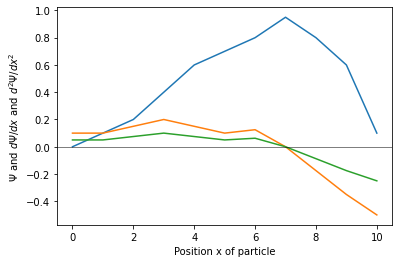

In [ ]:
#X = np.linspace(0, 10, endpoint=True)
#F1 = 3 * np.sin(X)

f1 = np.array([0, 0.1, 0.2, 0.4, 0.6, 0.7, 0.8, 0.95, 0.8, 0.6, 0.1], dtype=float)
f2 = np.gradient(f1)
f3 = np.gradient(f1, 2)
# https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
plt.plot(f1)
plt.plot(f2)
plt.plot(f3)
plt.axhline(y=0, color='black', linewidth=0.5, linestyle='-')
plt.xlabel("Position x of particle")
plt.ylabel("$\Psi$ and $d\Psi/dx$ and $d^2\Psi/dx^2$")
plt.show()

So we want to solve this equation:

> $\frac{-\hbar^{2}}{2 m}$ <font color="red">$ \frac{d^{2} \Psi}{d x^{2}}$</font> $=E \Psi$

* Normally try to solve <font color="red">$ \frac{d^{2} \Psi}{d x^{2}}$</font> which is second derivative of $\Psi$ with respect to x, when you know what $\Psi$ is, 

* but we don't. We want to go the other way around, which is trickier.

**Step 2: Rearrange the constants**

Luckily we have two constants in our equation (blue):

> <font color="blue">$\frac{-\hbar^{2}}{2 m}$</font> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$E$</font> $\Psi$

Which means we can rearrange the equation to this:

> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$\frac{-2m E}{\hbar^{2}}$</font>  $\Psi$

Now we can combine all constants in one constant $-k^2$ = $\frac{-2m E}{\hbar^{2}}$

> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$-k^2$</font>  $\Psi$


**Step 3: Identify suitable function for this equation**

* So which type of function obeys this relation $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$-k^2$</font>  $\Psi$? - Would be a [sinusoid](https://de.wikipedia.org/wiki/Sinusoid)!

* $\frac{d^2 y}{d x^{2}}=-y$ - when you start with a sine and differentiate it twice you still end up with a sinusoidal term

* so if we carefully account for the constants in our equation, our solution is going to look like a sinusoid:

> $\Psi$ = $\sin \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$ and replacing <font color="blue">$\frac{\sqrt{2 m E}}{\hbar}$</font> with $k$ $\rightarrow$ $\Psi$ = $\sin ($ <font color="blue">$k$</font> $x)$

*Compare this with before (above is no minus and root taken is first term):*

> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$\frac{-2m E}{\hbar^{2}}$</font>  $\Psi$ =  <font color="blue">$-k^2$</font>  $\Psi$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_176.png)

**Step 4: Work our the boundaries to solve the differential equation, which means to get wavefunction**


**When x = 0 $\rightarrow$ $\Psi$ = 0**

* so at the wall at point a $\Psi$ = 0, so that we first derivative is not getting infinite!

* this works quite nice with sinusoidal, since $\Psi = sin(kx)$ $\rightarrow$ 0 = sin(k(0)) = 0

**When x = a $\rightarrow$ $\Psi$ = 0**

* 0 = sin(k(a)) since $\Psi$ = sin(kx) $\rightarrow$ 0 = sin(k(a)) = 0

* we essentially find a restriction on the kind of sine wave that we can have as a solution

* for example half a sine wave is a possible solution

  * it's y=0 at point x=0 and x=a (at the walls), so $sin(ka) = 0$

  * so we went through half a sine wave which means that this part in brackets (ka) must be equal to 180 degrees (because that's half a sine wave) $y = \frac{1}{2}sin(x)$

  * and if we use radians instead of degrees, which is the other unit of measuring angles, and a much more natural unit of measuring angles, then 180 degrees is actually equal to <font color="blue">$\pi$ radians = (ka)</font>

  * So: $y = \frac{1}{2}sin(x) = \pi$

* this means that this equation holds true if our wavefunction is half a sine wave <font color="blue">$(ka)$ = $\pi$ = $\frac{\sqrt{2m E}}{\hbar}a$</font> , recall: k = $\frac{\sqrt{2m E}}{\hbar}$

* from earlier: $\Psi$ = $\sin \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$ =  $\sin ($ <font color="blue">$k$</font> $x)$



**Step 5: Rearrange that equation to get the energy value**


* and if we rearrange that <font color="blue">$(ka)$ = $\frac{\sqrt{2m E}}{\hbar}a$ = $\pi$ </font> we have something that tells us the value of the energy $E$:

> $E=\frac{h^{2} \pi^{2}}{2 m a^{2}}$

* (with reduced Planck constant: $\hbar=\frac{h}{2 \pi} =1.054571817 \ldots \times 10^{-34} \mathrm{~J} \cdot \mathrm{s}$)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_178.png)

* in other words: if our wavefunction looks like this (half a sine function), then the energy of our particle is this $E=\frac{h^{2} \pi^{2}}{2 m a^{2}}$

* another possibe solution is a full sine wave fitting into this region, just that the value at the end of the wall is 360 degrees, because we went through the whole sine wave = 2*$\pi$ radians

  * if the wavefunction looks like a whole sine wave <font color="blue">$\frac{\sqrt{2m E}}{\hbar}a$</font> = 2*$\pi$

  * then the  energy of the particle is $E=\frac{4h^{2} \pi^{2}}{2 m a^{2}}$

* We can continue doing this for lots of half sine waves, so we could have three or four half fine waves in our region - and in each case we can calculate the energy of a particle when its wavefunction looks like those sine waves. 

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_177.png)

* This phenomenom is called "Quantization".

  * because we can only have specific wave functions, and they correspond to specific energies, a particle can therefore only have specific energies

  * so it cannot be anyhting in between and it cannot be less than the minimum of half a sine wave $E_{1}=\frac{h^{2} \pi^{2}}{2 m a^{2}}$

  * this is also why for this particular setup cosine doesnt work (normally it does though) $\Psi=\cos \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$

**Step 6: Normalization to get probabilities**

*Normalization of the wavefunction*

* there is one more thing to consider when finding a solution to the Schrodinger equation: Normalization

> $\Psi = \sqrt{\frac{2}{a}} \sin \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$

* it adds a factor of $\sqrt{\frac{2}{a}}$ to our solution

* physical meaning: if our particle is in the lowest energy level $E_1$. Then in our specific setup with the two walls the wavefunction looks like half a sine wave. And remember the wavefunction corresponds directly to the probability of us finding that particle at a particular point in space. And this relationshipn is if we square our wavefunction $|\Psi|^2$ (we take the square modulus), then we get the probability

###### <font color="blue">**Eigenvalues (Eigenspectrum)**

> **Eigenvalue = Value of an observable, like principal quantum number or Drehimpuls, corresponding to the allowed energy levels of the quantum system**

**Eigenvalue Equation:**

> $Ax=\lambda x$

**In quantum mechanics, every experimental measurable $a$ is the Eigenvalue of a specific operator $(\hat{A}):$**

> $
\hat{A} \psi=a \psi
$

> <font color="blue">**The $a$ eigenvalues represents the possible measured values of the $\hat{A}$ (i.e. measurement) operator (z.B. stabile Energielevel)**</font>

* <font color="red">Eigenvalue = value of an observable, like principal quantum number or Drehimpuls, corresponding to the allowed energy levels of the quantum system</font>

* Classically, $a$ would be allowed to vary continuously, **but in quantum mechanics, $a$ Eigenvalues typically has only a sub-set of allowed values (hence the quantum aspect)**. 

* Both timedependent and time-independent Schrödinger equations are the best known instances of an eigenvalue equations in quantum mechanics, with its eigenvalues corresponding to the allowed energy levels of the quantum system

> **Messbar sind nur die Eigenwerte der Operatoren**. Hat z. B. der Hamiltonoperator, der die Energie eines quantenmechanischen Systems repräsentiert, ein diskretes Spektrum, so kann die Energie nur diskrete Werte annehmen, was z. B. für die Energieniveaus in einem Atom typisch ist. 


Die jeweils möglichen Messwerte n bilden das Spektrum der Observablen. Sie können sowohl diskret als auch kontinuierlich verteilt sein. Im diskreten Fall werden sie Eigenwerte der Observablen genannt. Meist wird der Einfachheit halber angenommen, dass das Spektrum rein diskret ist, obwohl wichtige Observable existieren, deren Spektrum rein-kontinuierlich ist (zum Beispiel Orts- und Impulsoperator).

**Spektrum**: Bereich der möglichen Messwerte. **Eigenvalues = z.B. stabile Energielevel**. For every problem there is a different hamiltonian and a different corresponding Eigenspectrum


###### <font color="blue">**Observables**

*Aus dem Chapter 'Quanten Numbers" zum Thema 'Observables':*

* A physical observable is anything that can be measured.

Siehe auch: ["Vollständiger Satz kommutierender Observablen"](https://de.wikipedia.org/wiki/Vollständiger_Satz_kommutierender_Observablen)

* Begriff aus der Quantenmechanik, in der Messgrößen wie Energie, Ort oder Impuls durch Operatoren dargestellt und als Observablen bezeichnet werden. 

* **Messgrößen, die man gleichzeitig genau bestimmen kann, heißen kommutierende Observablen; sie haben die Eigenschaft, dass ihre Operatoren miteinander vertauschen**.

* Solch ein Verhalten ist in der Quantenmechanik allerdings eher die Ausnahme. Die meisten Paare von Observablen lassen sich nicht gleichzeitig beliebig genau messen, was eine Konsequenz aus der heisenbergschen Unschärferelation ist. Man spricht dann auch von komplementären Observablen.

> **Messbar sind nur die Eigenwerte der Operatoren**. Hat z. B. der Hamiltonoperator, der die Energie eines quantenmechanischen Systems repräsentiert, ein diskretes Spektrum, so kann die Energie nur diskrete Werte annehmen, was z. B. für die Energieniveaus in einem Atom typisch ist. 


> **Um einen quantenmechanischen Zustand eindeutig zu charakterisieren, sind oft mehrere Observablen notwendig**. Beispielsweise ist es beim Wasserstoffatom nicht ausreichend, nur die Energie anzugeben (mittels der Hauptquantenzahl n), sondern es sind zwei weitere Observablen notwendig: der Betrag des Drehimpulses (Quantenzahl l) und die z-Komponente des Drehimpuls (Quantenzahl m). Diese drei Größen bilden dann einen vollständigen Satz kommutierender Observablen.


Eine Menge von Observablen A, B, C,... bildet einen v.S.k.O., wenn eine **orthonormale Basis des Zustandsraums aus gemeinsamen Eigenvektoren** der Observablen existiert, und diese Basis (bis auf einen Phasenfaktor) eindeutig ist.

Eine äquivalente Formulierung lautet: Eine Menge von Observablen A, B, C,... bildet einen v.S.k.O. genau dann, wenn:

* alle Observablen paarweise miteinander vertauschen, und

* <font color="red">**die Angabe der Eigenwerte aller dieser Operatoren ausreicht, um (bis auf einen Faktor) eindeutig einen gemeinsamen Eigenvektor zu bestimmen**.</font>

<font color="blue">Um ein quantenmechanisches Problem zu lösen, ist man bemüht eine Menge von Observablen zu finden, die das System beschreiben und einen v.S.k.O. bilden.</font>

* **Durch die Angabe der Messwerte der Observablen (das sind die Eigenwerte der Observablen**) ist es damit möglich den Zustand eines Systems eindeutig zu bestimmen. 

* Umgekehrt bedeutet das, dass man eine Messung auf einen vollständigen Satz kommutierender Observablen erstrecken muss, um den Zustand des Systems nach der Messung durch die Angabe der Messwerte eindeutig zu bestimmen.

> **Auch die Unmöglichkeit der gleichzeitigen präzisen Messung gewisser Größen (z. B. von Ort und Impuls), wie von der Heisenbergschen Unschärferelation ausgedrückt, ist letztlich darauf zurückzuführen, dass für die jeweiligen Operatoren kein gemeinsames System von Eigenvektoren existiert.**


###### <font color="blue">**Operators**

https://de.m.wikipedia.org/wiki/Linearer_Operator

Video: [Quantum Operators and Commutators](https://www.youtube.com/watch?v=so1szjHu7jY&list=WL&index=53)

* State of a quantum system described as a vector $x$, like spin up or down (spin = in-built angular momentum)

* for an electron the amount of spin it has is fixed

* but if we measure how the electron is spinning in one direction (like: spin up), then we could find one of two results

* these spins can be represented as vectors in some abstract space. Any quantum state that we can find our particle in behaves like a vector and interacts with other possible states (like normal: vectors interact with other vectors) 

* if a quantum state can be described like a vector, then making a measurement of a system can be treated mathematically as a matrix. 

	* These are the "measurement operators", like $S_z$ measures electron spin along z-direction.

> **More correct: the act of taking a measurement (like trying to find the spin of our electron) can be mathematically treated like a matrix $U$ or $T$**

From Video: [The SECOND Most Important Equation in Quantum Mechanics: Eigenvalue Equation Explained](https://youtu.be/zejh5yNkFpc)

https://www.youtube.com/watch?v=so1szjHu7jY&list=RDCMUC9lztld5qPi-6WZ9_QIVR6g&start_radio=1&rv=so1szjHu7jY&t=5

**Facts About Unitary Operators**

> Unitary operators are normal, so they are diagonalizable with respect to an orthonormal basis. Eigenvectors of a unitary operator associated with different eigenvalues are orthogonal. **The eigenvalues have [unit modulus](https://en.wikipedia.org/wiki/Absolute_value#Complex_numbers), that is, their form is $\mathrm{e}^{\mathrm{i} \alpha}$, where $\alpha$ is a real number**. Unitary operators preserve the inner product, that is, the inner product of $U\left|v_{1}\right\rangle$ by $U\left|v_{2}\right\rangle$ is equal to the inner product of $\left|v_{1}\right\rangle$ by $\left|v_{2}\right\rangle$. The application of a unitary operator on a vector preserves its norm.

> **In der Quantenmechanik werden Teilchen durch komplex-wertige Wellenfunktionen beschrieben und die unitäre Gruppe $U(1)$ wirkt auf diesen Wellenfunktionen durch punktweise Phasentransformation $f \rightarrow e^{i \theta} f$ des Funktionswerts. Das ist eine globale Eichinvarianz.** [Kreisgruppe / unitare Gruppe](https://de.m.wikipedia.org/wiki/Kreisgruppe#Physik)


*Typical Operators:*

* **Hamiltonian**: The Hamiltonian operator corresponds to the total energy of the system

* **Linear Momentum**: The linear momentum operator of a particle moving in one dimension (the x-direction) is

* **Position**: The position operator of a particle moving in one dimension (the x-direction) 

* **Kinetic Energy**: Classically, the kinetic energy of a particle moving in one dimension (the x-direction), in terms of momentum

* **Angular Momentum**: Angular momentum requires a more complex discussion, but is the cross product of the position operator r⃗̂ and the momentum operator  p̂

*Operate on the wavefunction with an operator*

In general, the wavefunction gives the "state of the system" for the system under discussion. It stores all the information available to the observer about the system. **Often in discussions of quantum mechanics, the terms eigenstate and wavefunction are used interchangeably**. The term eigenvalue is used to designate the value of measurable quantity associated with the wavefunction.

* If you want to measure the energy of a particle, you have to operate on the wavefunction with the Hamiltonian operator

* If you want to measure the momentum of a particle, you have to operate on wavefunction with the momentum operator

* If you want to measure the position of a particle, you have to operate on wavefunction with the position operator

* If you want to measure the kinetic energy of a particle, you have to operate on wavefunction with the kinetic energy operator

https://chem.libretexts.org/Courses/Pacific_Union_College/Quantum_Chemistry/03%3A_The_Schrodinger_Equation_and_a_Particle_in_a_Box/3.03%3A_The_Schrödinger_Equation_is_an_Eigenvalue_Problem

**<font color="orange">Ortsoperators $\hat{x}$</font>**

Der [Ortsoperator](https://de.m.wikipedia.org/wiki/Ortsoperator) gehört in der Quantenmechanik zur Ortsmessung von Teilchen.

* Der physikalische Zustand $\Psi$ eines Teilchens ist in der Quantenmechanik mathematisch gegeben durch den zugehörigen Vektor eines Hilbertraumes $\mathrm{H}$. 

* Dieser Zustand wird folglich in der Bra-Ket-Notation durch den Vektor $|\Psi\rangle$ beschrieben. 

* Die Observablen werden durch selbstadjungierte Operatoren auf $\mathrm{H}$ dargestellt.

Speziell ist der Ortsoperator die Zusammenfassung der drei Observablen $\hat{\mathbf{x}}=\left(\hat{x}_{1}, \hat{x}_{2}, \hat{x}_{3}\right)$, so dass

>$
E\left(\hat{x}_{j}\right)=\left\langle\hat{x}_{j} \Psi, \Psi\right\rangle_{\mathrm{H}}, \quad j=1,2,3
$

der Mittelwert (Erwartungswert) der Messergebnisse der j-ten Ortskoordinate des Teilchens im Zustand $\Psi$ ist.

https://de.m.wikipedia.org/wiki/Dirac-Notation#Darstellungen_in_der_Quantenmechanik

https://en.m.wikipedia.org/wiki/Position_and_momentum_space

**<font color="orange">Impulsoperators $\hat{p}$ (Momentum Operator)</font>**

Der [Impulsoperator](https://de.m.wikipedia.org/wiki/Impulsoperator) $\hat{p}$ ist in der Quantenmechanik der Operator zur Impulsmessung von Teilchen. In der Ortsdarstellung ist der Impulsoperator in einer Dimension gegeben durch:

>$
\hat{p}_{x}=-\mathrm{i} \hbar \frac{\partial}{\partial x}=\frac{\hbar}{i} \frac{\partial}{\partial x}
$

Dabei bezeichnet
- i die Imaginäre Einheit
- $\hbar$ die reduzierte Planck-Konstante und
- $\frac{\partial}{\partial x}$ die partielle Ableitung in Richtung der Ortskoordinate $x$.

Mit dem Nabla-Operator $\nabla$ erhält man in drei Dimensionen den Vektor:

>$
\hat{\mathbf{p}}=-\mathrm{i} \hbar \nabla
$

* Der physikalische Zustand $\Psi$ eines Teilchens ist in der Quantenmechanik mathematisch durch einen zugehörigen Vektor eines Hilbertraumes $\mathcal{H}$ gegeben. 

* Dieser Zustand wird folglich in der Bra-Ket-Notation durch den Vektor $|\Psi\rangle$ beschrieben. 

* Die Observablen werden durch selbstadjungierte Operatoren auf $\mathcal{H}$ dargestellt. 

* Speziell ist der Impuls-Operator die Zusammenfassung der drei Observablen $\hat{\mathbf{p}}=\left(\hat{p}_{1}, \hat{p}_{2}, \hat{p}_{3}\right)$, so dass

>$
E\left(\hat{p}_{j}\right)=\left\langle\Psi\left|\hat{p}_{j}\right| \Psi\right\rangle \quad j=1,2,3
$

der Mittelwert (Erwartungswert) der Messergebnisse der $j$ -ten Komponente des Impulses des Teilchens im Zustand $\Psi$ ist.

https://youtu.be/so1szjHu7jY

###### **<font color="blue">Hamiltonian Operator $\mathcal{H}$</font>**

> <font color="red">**The sum of the possible outcomes of kinetic and potential energy of this entire system in quantum mechanics is referred to the Hamiltonian $\mathcal{H}$ (to calculate the lowest total energy of a two atom system)**

> Hamiltonian Operator a set of operations **concerning interactions that dictate the state of the system** = Hamiltonian Operator typically describes the total energy of a system or particle.

https://de.m.wikipedia.org/wiki/Hamilton-Funktion

https://de.m.wikipedia.org/wiki/Hamiltonoperator

Spektrum: Bereich der möglichen Messwerte. Eigenvalues = stabile Energielevel. 

**For every problem there is a different hamiltonian and a different corresponding Eigenspectrum**.


Hamilton-Operator (Energie-Operator): Die Eigenzustaende dieses Energieoperators sind dann die Energiezustaende, die stabil sind. In der Atomphysik sind das dann die Zustande, die die Elektronen in den Orbitalen beschreiben


**Hamiltonian Operator and Time Evolution**

* Der Zustand eines quantenmechanischen Systems verändert sich mit der Zeit. Schwirrt beispielsweise ein Elektron durch ein Magnetfeld, ändert sich seine Flugbahn zu jedem Zeitpunkt. Eine berühmte lineare Abbildung diktiert diese Zeitentwicklung: Die zeitliche Änderung des Zustandsvektors ergibt sich durch die Anwendung des Hamilton-Operators auf diesen Vektor.

* Die vielleicht bedeutendste Eigenschaft des Hamilton-Operators besteht aber darin, dass sich die Energien eines physikalischen Systems in ihm verstecken. **Möchte man beispielsweise die verschiedenen Energieniveaus eines Atoms berechnen, genügt es, einige charakteristische Zahlen des entsprechenden Hamilton-Operators zu betrachten, die so genannten Eigenwerte**.

* Die gesamte Menge dieser Eigenwerte heißt »Spektrum« in Anlehnung an den gleich- namigen Begriff aus der Physik, der alle Energien bezeichnet, bei denen die Elektro- nenhülle eines chemischen Elements ein Photon absorbieren oder emittieren kann (siehe »Spektrum einer Welle«).

* Im Allgemeinen beschreibt der Hamilton-Operator also nicht bloß die zeitliche Entwicklung eines quantenmechanischen Objekts; seine Eigenwerte entsprechen au- ßerdem den Energien des Systems, und die dazugehörigen Eigenvektoren sind die Ba- siszustände. Das macht den Hamilton-Ope- rator zu einem der wichtigsten physikali- schen Werkzeuge.

*Quelle: Spektrum der Wissenschaft Spezial: Primzahlen*


Der [Zeitentwicklungsoperator](https://de.m.wikipedia.org/wiki/Zeitentwicklungsoperator) $\mathcal{U}$ bzw. $\mathcal{T}$ ist ein quantenmechanischer Operator, mit dem sich die zeitliche Entwicklung eines physikalischen Systems berechnen lässt. Der quantenmechanische Operator ist eng verwandt mit dem [Propagator](https://de.m.wikipedia.org/wiki/Propagator) in der Quantenfeld- oder Vielteilchentheorie. Üblicherweise wird er als $U\left(t, t_{0}\right)$ geschrieben und bezeichnet die Entwicklung des Systems vom Zeitpunkt $t_{0}$ zum Zeitpunkt $t$.

*Über die Exponentiation der Schrödingergleichung*

Der Zeitentwicklungsoperator $U\left(t, t_{0}\right)$ wird definiert über die Zeitentwicklung eines beliebigen Zustandes $|\psi\rangle$ zu einem Zeitpunkt $t_{0}$ bis zum Zeitpunkt $t$ :

>$
|\psi(t)\rangle=U\left(t, t_{0}\right)\left|\psi\left(t_{0}\right)\right\rangle \quad \forall|\psi\rangle
$

Einsetzen in die Schrödingergleichung liefert einen Satz gewöhnlicher Differentialgleichungen 1. Ordnung:

>$\mathrm{i} \hbar \frac{\partial}{\partial t} U\left(t, t_{0}\right)=H(t) U\left(t, t_{0}\right)$

Diese Gleichungen sind zur Schrödingergleichung insofern äquivalent, als sie die Erweiterung des Zeitentwicklungsoperators um einen infinitesimalen Zeitschritt $\delta t$ beschreiben:

>$
U\left(t+\delta t, t_{0}\right)=\left(1-\frac{i}{\hbar} H(t) \delta t\right) U\left(t, t_{0}\right)+O\left(\delta t^{2}\right)
$

mit dem Hamiltonoperator $H$, der den Erzeuger der Zeitentwicklungen darstellt.

https://en.m.wikipedia.org/wiki/Time_evolution (Evolution Operator)

**The Hamiltonian $\mathcal{H}$ operator describes the energy of a system (Classical Ising Model?)**: 

  * der [Hamiltonoperator](https://de.m.wikipedia.org/wiki/Hamiltonoperator) ist in der Quantenmechanik ein Operator, **der (mögliche) Energiemesswerte und die Zeitentwicklung angibt**. Er ist daher der Energieoperator. <font color="red">Er liefert beispielsweise die Energieniveaus des Elektrons im Wasserstoffatom.</font>

  * In der Quantenmechanik wird jeder Zustand des betrachteten physikalischen Systems durch einen zugehörigen Vektor $\psi$ im Hilbertraum angegeben. Seine Zeitentwicklung wird nach der Schrödingergleichung durch den Hamiltonoperator $\hat{H}$ bestimmt:

>$
\mathrm{i} \hbar \frac{\partial}{\partial t} \psi(t)=\hat{H} \psi(t)
$

  * mit der imaginären Einheit i
  
  * und der reduzierten Planckschen Konstante $\hbar=\frac{h}{2 \pi}$.

  * In der Eigenwertgleichung sind die Eigenwerte E die zugehörigen Energien.

**<font color="blue">More about: Hamilton Operator $\mathcal{H}$</font> (Classical Ising Model)**

https://de.wikipedia.org/wiki/Quantenmechanik#Stationäre_Zustände

weitergeleitet von hier:

https://de.wikipedia.org/wiki/Plancksches_Wirkungsquantum

https://de.m.wikipedia.org/wiki/Zufallsmatrix

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_009.png)

https://www.youtube.com/watch?v=Wy9YoEYv-fA&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=49

* A spin is a two state system, like two magnets that you approach each other and then they anti-align, so this will be their optimal energy configuration

* if you identify random variables with them, so sigma 1 = 1 for north up and sigma 2 = -1 for south up, and then you add another one and another one. You can write it as a sum of nearest neighbors. 

* this describes the energy of a system and we want to minimize it (naturally state in nature). 

* let's make it a bit more complicated: let's assume there is a wall that you can control between the magnets. With that you can change the strength of interaction between the individual pairs, you can change the coupling strengths - to include this in the equation, we add a term Ǝ

* now we complicate it a bit more and add an external magnetic field below each of these individual magnets. If this magnet field is strong enough, it can flip the magnet with the South Pole pointing to top and flip it upside down. This means the external magnet will overwrite the interactions that happen between the individual magnets. We model this external magnetic field influence by adding one more term to the equation, which is goin to be the strengths of this field h and the actual sigma value, the value of the random value in that spot. 

* this is actually a very hard problem to solve in nature: if you look at the energy landscape of this problem, and what can happen is that they might get stuck in some local optimum. And by overcoming this local barrier they could attain a better configuration.

* that's the same kind of problem we see in computer sciences in certain np hard problems: for example in the [quadratic unconstrained binary optimization problem (QUBO)](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization) it has a very similar form. You have binary random variables and you have some interaction strength between them (coefficients), and you have also a bias term affecting individual random variables. On a classical computer in the general case this takes exponentially many evaluations to find the global optimum. 

* so there is this natural correspondence between what's computationally hard and what's physically difficult to solve.



**Hamiltonian**

* the Hamiltonian has a formula where you input the state of the system and it outputs the energy of the system (both quantum & classical system)

* inout state of all qubits, Hamiltonian will give energy of that state 

* Quantum annealing: tries to find state of all qubits that gives us lowest energy

* lowest energy state of initial Hamiltonian is when all the qubits are in a superposition state of zero and one (easy set up of the system)

* Ideally you stay in the minimum energy state throughout the quantum annealing procedure (In annealing: initially quantum states, at the end classical states)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_009a.png)

###### <font color="blue">**Eigenstates (Eigenvector)**

> **Eigenstate = Wavefunction $\psi$**

**Some states are Eigenstates of a measurement**

* For example before we make our measurement the electron happens to be in the spinning clockwise state $|1\rangle$

* if we then make a spin measurement of the state of this electron stays the same, making a measurement does not affect our system

* <font color="blue">**What we end up measuring when we make our measurement is the Eigenvalue, like $\frac{\hbar}{2}$ in: $S_z$ $|1\rangle$ = $\frac{\hbar}{2}$ $|1\rangle$**</font>

	* $S_z$ $\rightarrow$ measurement operator matrix $A$

	* $\frac{\hbar}{2}$ $\rightarrow$ Eigenvalue $\lambda$

	* $|1\rangle$ $\rightarrow$ state stays the same, the Eigenstate $|\psi \rangle$, in the Eigenvalue equation it is $x$

	* <font color="red">You can see the similarity with the Eigenvalue Equation: $Ax=\lambda x$ with: $S_z$ $|1\rangle$ = $\frac{\hbar}{2}$ $|1\rangle$</font>



* Our measurement result would be an angular momentum of $\frac{\hbar}{2}$ with $\hbar$ known as the "Reduced Planck Constant" : this is the numerical value we'll find

* Eigenstates of of any operator always behave like perpendicular vectors, there is no component of one vector in the other (there is no way to write one vector in terms of another)

* <font color="blue">So, in many ways making a measurement on a system that is already in an Eigenstate is pretty intuitive: **the system remains in the same state and the numerical result we get because of our measurement is the Eigenvalue of the state: multiplying the vector with the measurement matrix doesn't change the vector, so the value in front of the vector (its energy state) is the Eigenvalue, and the vector itself the Eigenvector!**</font>

* an operator that represents a spin measurement in this direction for an electron has two Eigenstates: clockwise and anti clockwise spin

> **Auch die Unmöglichkeit der gleichzeitigen präzisen Messung gewisser Größen (z. B. von Ort und Impuls), wie von der Heisenbergschen Unschärferelation ausgedrückt, ist letztlich darauf zurückzuführen, dass für die jeweiligen Operatoren kein gemeinsames System von Eigenvektoren existiert.**


**What happens if our system is initially not in an Eigenstate? What if we apply our measurement operator to some other state vector?**

> $S_{z} |\psi\rangle =?$ $\rightarrow$ With $|\psi\rangle$ being a general state (not Eigenstate!)

* **applying a matrix to a vector that was not an Eigenvector, then that vector ends up getting transformed**. Similarly in quantum mechanics, a state that is not an Eigenstate or Eigenvector of our measurement operator

* Remember an electron can be in a superposition of multiple states. This quantum state is created by a linear combination of some amounts of spin up probability and spin down probability

* What this means is that the electron has some probability of being found in either state when we make our spin measurement. **And this is what happens when we make our measurement on a non-Eigenstate**. 

> <font color="blue">**By some random process that we don't fully understand yet a measurement causes the state to change into one of the Eigenstates.** </font>

* And we can even calculate the probability with which our measurement will result in one state vs the other. (The probability for a particular result is just the square of this quantity)

> <font color="blue">**Even if the system is not in an Eigenstate but in a superposition of states, the Eigenvalue equation is still important because it helps us figuring out the possible measurement results we could find when we make the measurement on our system.**</font>

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_152.png)

Worth mentioning: slight difference between what happens when you apply a transformation matrix to a normal vector, like here: $\left[\begin{array}{cc}17 & -35 \\ 6 & -12\end{array}\right]\left(\begin{array}{l}1 \\ 1\end{array}\right)=\left(\begin{array}{c}-18 \\ -6\end{array}\right)$ 

and what happens when you apply a measurement operator to a quantum state that isn't an Eigenstate $S_{z}\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}} |1\rangle\right)$:

* whereas in the mathematical scenario every matrix can be applied to any vector, and you can calculate exactly what the resultant vector should be, 

* **in the quantum case, because we are talking about superposition of states, this results in a random collapse into one of the possible Eigenstates**

* **Eigenvektor: Vektoren, die bei einer Transformation mit einer Matrix ihre Richtung nicht ändern**. 

* Z.B. Rotationen um eine Achse = Achse bleibt fest und ist Eigenvektor (bei einfachen Rotationen Eigenwert = 1). 

* in mechanik: trägheitsmoment gegenüber rotationen. Hauptachsen mit Tensorrechnung. die hauptachsen sind diejenigen richtungen, in die die drehungen stabile verlaufen. drehimpuls und winkelgeschwindigkeit haben gleiche richtung. keine schwankungen der drehachsen, sie sind stabil. (https://www.grund-wissen.de/physik/mechanik/kinematik/kreisfoermige-bewegungen.html)

* **Quantenmechanik: hermetische Operatoren. Diese führen zu Eigenwerten und Eigenvektoren**. 

	* Interessant ist bei solchen Operatoren bzw. bei den linearen Abbildungen bei den symmetrischen Matrizen im Reellen: Eigenvektoren stehen im reellen senkrecht aufeinander. (Bilden eine Orthonormalbasis). 

	* Man kann Vektorraum mit diesen Eigenvektoren aufspannen und jeden Vektor als Linearkombination dieser Eigenvektoren darstellen.

	* **Dann ist das Verhalten der Abbildungen quasi reduziert auf das Verhalten der Eigenvektoren mit ihren entsprechenden Eigenwerten, so dass dann jeder Vektor wenn man ihn in die Basis der Eigenvektoren schreibt, relativ einfach transformiert werden kann**, indem man einfach die entsprechenden Eigenvektor-Skalierungen beachtet und später die Summe immer wieder bildet (ist ja alles linear).

**Spezielle Vektoren der Quantenmechanik**:

* Hamilton-Operator (Energie-Operator): Die Eigenzustaende dieses Energieoperators sind dann die Energiezustaende, die stabil sind. In der Atomphysik sind das dann die Zustande, die die Elektronen in den Orbitalen beschreiben

* Genauso gibt es Eigenvektoren zu den Drehimpuls-Operatoren (und zu anderen Dingen). Hier kommt Eigenwert-Theorie zum blühen. Die entsprechende Orthonormal-Basis ist dann auch die Basis in der man jede beliebigen Zustand des Systems beschreiben kann. 

###### <font color="blue">**Eigenfunction**

> <font color="red">**So stellen bei den Lösungen der bekannten Schrödingergleichung die Eigenwerte die erlaubten Energiewerte der Elektronen und die Eigenfunktionen die zugehörigen Wellenfunktionen der Elektronen dar.**


Die jeweils möglichen Messwerte n bilden das Spektrum der Observablen. Sie können sowohl diskret als auch kontinuierlich verteilt sein. Im diskreten Fall werden sie Eigenwerte der Observablen genannt. **Meist wird der Einfachheit halber angenommen, dass das Spektrum rein diskret ist, obwohl wichtige Observable existieren, deren Spektrum rein-kontinuierlich ist (zum Beispiel Orts- und Impulsoperator).**

> <font color="red">Die zu den Eigenwerten zugehörigen Zustände $|n\rangle$ werden als **Eigenzustände** der Observablen bezeichnet. <u>Bei kontinuierlichem Spektrum spricht man von verallgemeinerten **Eigenfunktionen**</u>. Dabei handelt es sich um **Distributionen** wie die Dirac-Funktion.

* [Eigenwerte](https://de.m.wikipedia.org/wiki/Eigenwertproblem) spielen in der Quantenmechanik eine besondere Rolle. Physikalische Größen wie z. B. der Drehimpuls werden hier durch Operatoren repräsentiert. 

* **Messbar sind nur die Eigenwerte der Operatoren**. Hat z. B. der Hamiltonoperator, der die Energie eines quantenmechanischen Systems repräsentiert, ein diskretes Spektrum, so kann die Energie nur diskrete Werte annehmen, was z. B. für die Energieniveaus in einem Atom typisch ist. 


* <font color="blue">It is a general principle of Quantum Mechanics that there is an operator for every physical observable.</font>

* A physical observable is anything that can be measured.

> <font color="red">**If the wavefunction that describes a system is an <u>eigenfunction</u> of an operator, then the value of the associated observable is extracted from the eigenfunction by operating on the eigenfunction with the appropriate operator.**</font>

> **The value of the observable for the system is the eigenvalue, and the system is said to be in an <u>eigenstate</u>.**

* Equation $
\hat{H} \psi(x)=E \psi(x)
$ states this principle mathematically for the case of energy as the observable.


* The operators must yield real **eigenvalues**, since they are values which may come up as the result of the experiment. Mathematically this means the operators must be Hermitian.

* The probability of each eigenvalue is related to the projection of the physical state on the subspace related to that eigenvalue.

> Spektrum: Bereich der möglichen Messwerte

* Eigenvalues = stabile Energielevel

* For every problem there is a different hamiltonian and a different corresponding Eigenspectrum 

> **Auch die Unmöglichkeit der gleichzeitigen präzisen Messung gewisser Größen (z. B. von Ort und Impuls), wie von der Heisenbergschen Unschärferelation ausgedrückt, ist letztlich darauf zurückzuführen, dass für die jeweiligen Operatoren kein gemeinsames System von Eigenvektoren existiert.**


###### <font color="blue">**Schrödinger equation: Time Independent (Eigenvalue Equation)**</font>

https://de.m.wikipedia.org/wiki/Schrödingergleichung 


**The Schroedinger equation can be written as a type of Eigenvalue equation**

> $\hat{H}|\psi\rangle= -i \hbar \frac{d}{d t}|\psi\rangle =\frac{\hbar}{i} \frac{d}{d t}|\psi\rangle$

Mit dem Impulsoperator (stimmt das?):

>$
\hat{p}_{x}=-\mathrm{i} \hbar \frac{\partial}{\partial x}=\frac{\hbar}{i} \frac{\partial}{\partial x}
$

**Simplified (when system is not changing over time: time-independent Schroedinger equation):**

> $\hat{H}|\psi\rangle=E |\psi\rangle$

* $\hat{H}$  - measurement operator (matrix): measures the total energy of a system

* $E$ - Eigenvalue: is the numerical energy value that we measure

* $|\psi\rangle$ - Eigenstates / Eigenvector: are the various Eigenstates that we can measure

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_151.png)

**From video [Crash course in density matrices](https://youtu.be/1tserF6VGqI):**

**Dynamics: if we want to study how a quantum system changes in time, we usually refer to the Schroedinger equation.**

> $i \frac{d}{d t}|\psi(t)\rangle=\hat{H}|\psi\rangle$

* the operator $\hat{H}$ is called the Hamiltonian and it tells us about the total energy in a system, and how things in a system interact with each other.

* **The easiest way to solve this problem is to first solve the Eigenvalue problem**, which involves finding the Eigenvectors and the Eigenvalues of the hamiltonian. We are able the different values of the Eigenvalues and Eigenvectors with the label k:

> $\hat{H}\left|E_{k}\right\rangle=E_{k}\left|E_{k}\right\rangle$

* This allows us to know that the Eigenvectors, when plugged into the Schroedinger equation ...

> $i \frac{d}{d t}\left|E_{k}\right\rangle=\hat{H}\left|E_{k}\right\rangle=E_{k}\left|E_{k}\right\rangle$

* **... just pick up a phase in time depending on the energy they correspond to**:

> $\left|E_{k}(t)\right\rangle=e^{-i E_{k} t}\left|E_{k}\right\rangle$

**Now to sum more general situation with some generic state $\psi$**

* we can decompose $\psi$ in terms of energy Eigenbasis:

> $|\psi\rangle=\sum_{m} c_{m}\left|E_{m}\right\rangle$

* where $c_{m}$ is given by the inner product of the energy Eigenvector labelled by m and $\psi$ itself:

> $c_{m}=\left\langle E_{m} \mid \psi\right\rangle$

* We can then time-evolve the state by simply time-evolving the energy Eigen-Kets:

> $|\psi(t)\rangle=\sum_{m} c_{m} e^{-i E_{m} t}\left|E_{m}\right\rangle$

* Tracking the expectation value of an observable is quite easy: Simply applying the state vector in time to both sides of the matrix gives the following equation: 

> $\langle A(t)\rangle=\sum_{m, n} \bar{c}_{n} c_{m} A_{n, m} e^{i\left(E_{n}-E_{m}\right) t}$

* Where we have labelled the matrix entries of a by the energy Eigenbasis in the following way:

> $A_{n, m}=\left\langle E_{n}|A| E_{m}\right\rangle$

**Schrödinger Equation: Time-<font color="blue">Independent</font> Version**

Video: [What is The Schrödinger Equation, Exactly?
](https://youtu.be/QeUMFo8sODk)

> $E \Psi(x)=\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi(x)}{d x^{2}}+V \Psi(x)$

* E = **Energy the electron** is allowed to have

* $\Psi$ = **Wavefunction** (most likely position of an electron)

* **Kinetic energy**: $\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi(x)}{d x^{2}}$ (klassische Form: $K E=\frac{1}{2} m v^{2}$)

* **Potential energy**: $V \Psi(x)$

*What would a typical Schroedinger solution look like? - All the solutions to the wave function take these two forms:*

> $\Psi(x)=\sqrt{\frac{2}{L}} \cos \left(\frac{\pi n x}{L}\right)$ when $n=1,3,5 \ldots$ (is odd $)$

> $\Psi(x)=\sqrt{\frac{2}{L}} \sin \left(\frac{\pi n x}{L}\right)$ when $n=2,4,6 \ldots$ (is even)

*Now looking at $\psi$, the probable position of an electron:*

* central question: where is the electron?

* n is the energy state / level of an electron (look above at quantum numbers)

* When an electron is state n=1 (its first energy state) we apply the first formula: $\Psi(x)=\sqrt{\frac{2}{L}} \cos \left(\frac{\pi n x}{L}\right)$

* then we get wave function for the electron that is in a given box in this case:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_147.png)

* And if we square it, we get the probability distribution (the probable position of an electron):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_148.png)


* And here some wave functions and probability densities for other energy states:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_149.png)



*And the solution that popped out was this:*

> $E=\frac{\hbar^{2} n^{2} \pi^{2}}{2 m L^{2}}$

* Everything is a constant ($\hbar$, $\pi$, 2, m, L) or a whole number (here: n, which stands for the different states of an electron)

* which means that energy E can ony have certain discrete (=quantum) values

###### <font color="blue">**Schrödinger equation: Time Dependent**

**Consider: Difference of probability in the position basis (changes over time) and the energy basis (doesn't change):** 

> <font color="red">**The electron is still in the same shell, represented by the principal quantum number for example, because if the electron changes the shell, energy needs to be added or removed from the overall system. however if energy stays the same, it means the electron is still in the same shell, but "moving" around = probability distribution of finding it somewhere in this shell changes over time which is represented by the rotation $e^{i \frac{\hat{H} * t}{\hbar}}$**</font>

Die [Schrödingergleichung](https://de.wikipedia.org/wiki/Schrödingergleichung) ist eine grundlegende Gleichung der Quantenmechanik. Sie beschreibt in Form einer partiellen Differentialgleichung die zeitliche Veränderung des quantenmechanischen Zustands eines nichtrelativistischen Systems. Die Gleichung wurde 1926 von Erwin Schrödinger zuerst als Wellengleichung aufgestellt und bei ihrer ersten Anwendung erfolgreich zur Erklärung der [Spektren des Wasserstoffatoms](https://de.wikipedia.org/wiki/Wasserstoffatom#Lösung_der_Schrödinger-Gleichung_(Wasserstoffproblem)) genutzt.


>$
\left[-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})\right] \psi(\vec{r})=E \psi(\vec{r})
$

The object on the left that acts on $\psi(x)$ is an example of an operator.

>$
\left[-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})\right]
$ = Operator

In effect, what is says to do is "take the second derivative of $\psi(x)$, multiply the result by $-\left(\hbar^{2} / 2 m\right)$ and then add $V(x) \psi(x)$ to the result of that." 

Quantum mechanics involves many different types of operators. This one, however, plays a special role because it appears on the left side of the Schrödinger equation. **It is called the Hamiltonian operator and is denoted as**

> $
\hat{H}=-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})
$

**Therefore the time-dependent Schrödinger equation can be written as**:

> $
\hat{H} \psi(x, t)=i \hbar \frac{\partial}{\partial t} \psi(x, t)
$

with $\hat{H}$ = $(-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r}))$ will be:

> $
(-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})) \; \psi(x, t)=i \hbar \frac{\partial}{\partial t} \psi(x, t)
$

bzw. rewritten:

> $\left[-\frac{\hbar^{2}}{2 m} \frac{\partial^{2}}{\partial x^{2}}+V(x, t)\right] \Psi(x, t) = i \hbar \frac{\partial}{\partial t} \Psi(x, t)$

bzw written in another way (single particle variant):

> <font color="red">$[-\frac{\hbar^{2}}{2 m} \nabla^{2} $</font> + <font color="green">$V(x, t)$</font> ] 
 <font color="blue">$|\psi\rangle$</font> = $i \hbar \frac{\partial}{\partial t}$ <font color="blue">$|\psi\rangle$</font>

* <font color="red">$[-\frac{\hbar^{2}}{2 m} \nabla^{2} $</font> Kinetic energy

* <font color="green">$V(x, t)$</font> Potential energy

* <font color="blue">$|\psi\rangle$</font>  the wave function

https://en.wikipedia.org/wiki/Schrödinger_equation

https://www.youtube.com/watch?v=w9Kyz5y_TPw

<font color="blue">**Schrödinger equation: Time Evolution (Derivation)**

From Video: [The Schrodinger equation made simple | Linearity](https://youtu.be/ZfKq3g3MHqE)

Physics: given an initial state x and its velocity, what's the position at time x later? This is what we want also in quantum mechanics!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_153.png)

That's what the Schroedinger equation is for: to say what's the future state of a system?

> $i \hbar \frac{\partial}{\partial t} |\Psi (t) \rangle = -\frac{\hbar^{2}}{2 m} \nabla^{2} |\Psi (t) \rangle +\hat{V} |\Psi (t) \rangle$

Easier form:

> $|\Psi (t) \rangle = e^{\frac{i H t}{\hbar}} |\psi (0) \rangle$

* the state of a quantum particle of given by the wave function

* $|\psi (0) \rangle$ this is the wave function at the start, the Schrodinger equation tells you that the time evolver $e^{\frac{i H t}{\hbar}}$ acts on the original wave function to produce the wave function t seconds into the future $|\Psi (t) \rangle$

* **So what is this transformation (time evolver) $e^{\frac{i H t}{\hbar}}$ and why is it that way?**

  * it comes down to conservation of energy

  * time evolution is linear

  * if I have an object and 2 different possible states $\alpha |0\rangle$ and $\beta |1\rangle$ to start with. we apply time evolution to each and then we see how they evolve.
  
  * and then imagine I have a superposition of these two states $\alpha |0\rangle$ and $\beta |1\rangle$. It will be a superposition of the evolution of each of the states. the final outcome is a linear combination of those two: $\alpha |0\rangle$ + $\beta |1\rangle$

  * **The time evolution of a superposition is the linear combination of the time evolution of each of the states.**

  * This even holds if you write the same state in a different basis, for example instead a position basis you choose a momentum basis. So these two states are then equal to each other: they are both the future state. 

* So the general statement of linearity is this, which $T$ being the time evolution operator $e^{\frac{i H t}{\hbar}}$:

> $T |\Psi_{(t=0)} \rangle =  \alpha_1 |\Psi (0) \rangle + \alpha_2 |\Psi (1) \rangle + \alpha_3 |\Psi (2) \rangle$

> $T |\Psi_{(t=0)} \rangle =  \alpha_1 T|\Psi (0) \rangle + \alpha_2 T|\Psi (1) \rangle + \alpha_3 T|\Psi (2) \rangle$

* each part of the superposition evolves completely unaware and independent of the other superposition part.

* this breaks only by measurement. During the measurement, the branches of the superposition have the chance to interact with each other (so it's not linear anymore). So, **measurement doesn't follow the Schrodinger equation ('the measurement problem')**. (Many worlds and pilot-wave mechanics were proposed to get around this).

**If you have a superposition of some states and you apply the time evolution operator**:

> $T\left(\alpha_{1}\left|\psi_{1}\right\rangle+\alpha_{2}\left|\psi_{2}\right\rangle+\ldots\right)=\alpha_{1} T\left|\psi_{1}\right\rangle+\alpha_{2} T\left|\psi_{2}\right\rangle+\ldots$

You can also write each of these in the energy Eigenbasis (because time evolution is very easy in that basis):

> $\left|\psi_{1}\right\rangle=\beta_{11}\left|E_{1}\right\rangle+\beta_{12}\left|E_{2}\right\rangle+\ldots$

> $\left|\psi_{2}\right\rangle=\beta_{21}\left|E_{1}\right\rangle+\beta_{22}\left|E_{2}\right\rangle+\ldots$

this will turn into:

> $=T\left(\alpha_{1}\left(\beta_{11}\left|E_{1}\right\rangle+\beta_{12}\left|E_{2}\right\rangle+\ldots\right)+\alpha_{2}\left(\beta_{21}\left|E_{1}\right\rangle+\beta_{22}\left|E_{2}\right\rangle+\ldots\right)+\ldots\right.$

and factoring in and rewriting the time evolution operator $T = e^{\frac{i \mathcal{H} t}{\hbar}} = e^{\frac{i E t}{\hbar}}$:

> $=\alpha_{1}\left(\beta_{11} e^{\frac{i E_1 t}{\hbar}}\left |E_{1}\right\rangle+\beta_{12} e^{\frac{i E_2 t}{\hbar}} \left|E_{2}\right\rangle+\ldots\right)+\alpha_{2}\left(\beta_{21} e^{\frac{i E_1 t}{\hbar}} \left|E_{1}\right\rangle+\beta_{22} e^{\frac{i E_2 t}{\hbar}} \left|E_{2}\right\rangle+\ldots\right)+\ldots.$

Taken from [Schrodinger equation comment response and homework answers video](https://www.youtube.com/watch?v=M_2h5uQ0SIc)

<font color="blue">**Schrodinger equation: Derivation and how to use it (in Time Evolution)**

From Video [Schrodinger equation | Derivation and how to use it](https://www.youtube.com/watch?v=DEgWbrMv6-k)

Important rules of physics:

* Conservation of energy -> deeply integrated into Schrodinger equation
* total energy doesn't change
* you can't make of destroy energy

**Since we can write a quantum state $|\Psi \rangle$ in whatever basis we want, we can choose the energy Eigenbasis**. <font color="red">what is meant by that? is that the principle quantum number for example</font>

* We can write a state as the superposition of different energies. 

* And if we measure the energy of the particle it will be one of these with their probability

> $|\Psi \rangle$ = $\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle$ 

* with probability for example $|\beta|^2$ for measuring second state

**Say the state evolves in time, in other words we apply the time evolution $U$ (or $T$) to $|\Psi \rangle$, so $T |\Psi \rangle$** 

* what condition do we want to impose on the new energies of the state? 

* In other words: how we want conservation of energy to look in quantum mechanics?

**Let's start where a particle just has one energy $E$ when we start**

* means: it is an energy Eigenstart !!

* we evolve it forward in time and look at the energy of the new state. That energy should be also $E$, otherwise energy wouldn't be conserved (Like in classical mechanics).

> $|\Psi \rangle$ = $|1 \rangle$ $\rightarrow$ $T|\Psi \rangle$

* Now also the average energy shouldn't change after some time, otherwise the energy wouldn't be conserved either.

> $|\Psi \rangle$ = $\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle$ 

* if you measured athe particle's energy initially with a certain probability $|\beta|^2$, and then after time evolution again, it should be the same probability to measure that energy!

* this is so strong, it gives us the schroedinger equation

**We need to how the coefficients have changed in the new equation after time evolution**:

> $|\Psi \rangle$ = $\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle$ (before)

> $T |\Psi \rangle$ = $\alpha' |\Psi \rangle + \beta' |\Psi \rangle + \gamma' |\Psi \rangle$ (after)

* We want the probability to be the same, but that probability is just the lenght of this compex number squared $|\gamma|^2 = |\gamma'|^2 = 1$

> <font color="red">**So each coefficient can be represented as an arrow with equal length $|\gamma|^2$ and $|\gamma'|^2$ (hence the probability of measuring that energy this state is still the same!!), BUT $|\gamma'|^2$ may be rotated by an angle $\phi$**. This angle is new vector = rotation * old vector:</font>

> <font color="red">$\gamma' = e^{i\phi}\gamma$</font>

Let's plug that rotation $e^{i\phi}$ in to our previous equation:

> <font color="red">$T |\Psi \rangle$ = $e^{i\phi_1}\alpha |\Psi \rangle + e^{i\phi_2}\beta |\Psi \rangle + e^{i\phi_3}\gamma |\Psi \rangle$</font>

* where the angles / rotations $e^{i\phi}$ are different for every energy = they are all rotated by a different amount !! Otherwise the rotation can be brought out and present and future state would be the essentially same:

> $T |\Psi \rangle$ = $e^{i\phi}\alpha |\Psi \rangle + e^{i\phi}\beta |\Psi \rangle + e^{i\phi}\gamma |\Psi \rangle$ = $e^{i\phi} (\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle)$ (this is showing that it's wrong!)

The overall rotation wouldn't affect any measurement outcomes. Means no matter in which crazy situation you brought the particle in, it does nothing, which can't be right.

> $T |\Psi \rangle$ = $e^{i\phi}|\Psi \rangle$ (this is showing that it's wrong!


* also the amount of rotation depends on time (little going forwardf = little rotation). That suggests the right amount of angle to rotate is Energy x Time. Plus some constants to deal with units and scaling etc.

> <font color="red">$\phi = \frac{E * t}{\hbar}$</font>

* And that's what the Schroedinger equation will tell you will happen to the state:

> $T |\Psi \rangle$ = $e^{i \frac{E * t}{\hbar}}\alpha |\Psi \rangle + e^{i \frac{E * t}{\hbar}}\beta |\Psi \rangle + e^{i \frac{E * t}{\hbar}}\gamma |\Psi \rangle$

* And that's the same: (with $\hat{H}$ for energy measurement operator, Hamiltonian):

> <font color="red">$T(t) |\Psi \rangle = e^{i \frac{\hat{H} * t}{\hbar}}|\Psi \rangle$</font>


**Let's apply this a bit**

We can show the probabilities in the energy basis also in the position basis: Suppose that in the position basis, each of these had wave function that looked like this:


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_154.png)

Then at the start, adding them up, the probability of finding a particle at various points looks like this:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_155.png)


But see how this evolves in time to give a probability  distribution that changes dramatically:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_156.png)

The reason is these complex numbers: at the start they all just added like normal to give you this. 

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_157.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_155.png)


But later in time, when these complex numbers are pointing different ways, they don't just add up anymore. As an extreme example, if the two arrows from the second and third part pointed in opposite directions, they would subtract from one another. This is why the overall wave function in the position basis can vary so much over time:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_158.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_159.png)

This means depending on the time one measures, the particle might have a very big probability of ending up here versus there:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_160.png)




**Yet if you measure energy, you always get one of these three energies with these probabilities, no matter what time it is:** 

> <font color="red">**I guess this means that the electron is still in the same shell, represented by the principal quantum number for example, because if the electron changes the shell, energy needs to be added or removed from the overall system. however if energy stays the same, it means the electron is still in the same shell, but "moving" around = probability distribution of finding it somewhere in this shell changes over time which is represented by the rotation $e^{i \frac{\hat{H} * t}{\hbar}}$**</font>

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_161.png)

One last thing: **How do we know what the energy Eigenbasis is?**

* if we take an energy Eigenvector, how do we find what it looks in the position basis?

* Schrodinger also gave us an equation that defines what an energy Eigenstate is:

> $\hat{H} = \frac{\hat{p}^2}{2m}+ \hat{V}$

* $\hat{H}$ being the total energy

* $\frac{\hat{p}^2}{2m}$ being kinetic energy

* $\hat{V}$ being potential energy

**The issue is that this equation is extremely hard to solve.** Probably impossible to solve for anything bigger than 2 particles, maybe with quantum computers. That's why physical chemists do so much hard work on the Schrodinger equation 

**Common result for 2 observations:**

Time Evolution per each step, observer 1:

> $| \Psi \rangle$ $\rightarrow$ at $t_1$ = $e^{\frac{i \mathcal{H} t_1}{\hbar}} | \Psi \rangle$ $\rightarrow$ at $t_2$ = <font color="blue">$e^{\frac{i \mathcal{H} t_2}{\hbar}} (e^{\frac{i \mathcal{H} t_1}{\hbar}} | \Psi \rangle)$</font>

Time Evolution at the end for observer 2 (not seeing time step 1):


> $| \Psi \rangle$ $\rightarrow$ at $t_2$ = <font color="orange">$e^{\frac{i \mathcal{H} (t_1 + t_2)}{\hbar}} | \Psi \rangle$</font>

Where:

> <font color="orange">$e^{\frac{i \mathcal{H} (t_1 + t_2)}{\hbar}} | \Psi \rangle$</font> = <font color="blue">$e^{\frac{i \mathcal{H} t_2}{\hbar}} (e^{\frac{i \mathcal{H} t_1}{\hbar}} | \Psi \rangle)$

Why? - because our angle of rotation depends on $t$ (and not $t^2$ or anything): $T\left(t_{1}+t_{2}\right)=T\left(t_{2}\right) T\left(t_{1}\right)$

Taken from [Schrodinger equation comment response and homework answers video](https://www.youtube.com/watch?v=M_2h5uQ0SIc)

###### <font color="blue">**Miscellaneous**

> **Objective: Find out the allowed energy levels of the wave functions of an electron**

> **If we want to study how a quantum system changes in time, we usually refer to the Schroedinger equation.**

* Einstein discovered that energy is proportional to $h$ * frequency: $E = h * f$

* $h$ is Planck's constant ([Plancksches Wirkungsquantum](https://de.wikipedia.org/wiki/Plancksches_Wirkungsquantum))

* Beziehung zwischen der Energie eines Teilchens oder physikalischen Systems und der Frequenz seiner quantenmechanischen Phase ( = [Stationäre Zustände](https://de.wikipedia.org/wiki/Quantenmechanik#Stationäre_Zustände), Eigenzustände zum Hamilton-Operator $\hat H$ )

* nur bestimmte Frequenzen sind erlaubt, damit sind auch nur bestimmte energy levels fur ein elektron erlaubt, was man wiederum mit der schroedingergleichung ermitteln kann

**More on Schrödinger Equation**:

> $i \hbar \frac{\partial}{\partial t} \psi(\mathbf{r}, t)=-\frac{\hbar^{2}}{2 m} \nabla^{2} \psi(\mathbf{r}, t)+V(\mathbf{r}, t) \psi(\mathbf{r}, t)$

* $i$ is the imaginary number, $\sqrt{-1}$.

* $\hbar$ is Planck's constant divided by $2 \pi: 1.05459 \times 10^{-34}$ joule second. 

* $\psi(\mathbf{r}, \mathrm{t})$ is the wave function, defined over space and time.

* $m$ is the mass of the particle.

* $\nabla^{2}$ is the Laplacian operator, $\frac{\partial^{2}}{\partial x^{2}}+\frac{\partial^{2}}{\partial y^{2}}+\frac{\partial^{2}}{\partial z^{2}}$

The general form is:

> $\hat{H} \Psi=E \Psi$

* $\hat{H}$: hamiltonian operator (energy operator)

* $E$: Energy eigenvalue

https://medium.com/nieuwsgierigheid/machine-learning-quantum-physics-27e316d4ed77

> $
\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \Psi}{\partial x^{2}}=i \hbar \frac{\partial \Psi}{\partial t}
$

Schrodinger equation for free particle
in one dimension

http://hyperphysics.phy-astr.gsu.edu/hbase/quantum/Schr2.html

<font color="orange">**Von Neumann Equation of Time Evolution</font>**

> $
i \frac{\partial \rho}{\partial t}=[\hat{H}, \rho]
$

Features the commutation relationship between the hamiltonian and the density matrix itself

https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Time_Dependent_Quantum_Mechanics_and_Spectroscopy_(Tokmakoff)/05%3A_The_Density_Matrix/5.02%3A_Time-Evolution_of_the_Density_Matrix

**<font color="orange">Quantum Many-Body Physics</font>**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_011.png)

https://www.youtube.com/watch?v=MmpOva4-XPg&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=51

* The Schroedinger Equation gives us the time evolution of a quantum system, it includes the wave function

* the wave function is the quantum state of the particle or system of particles

* its time evolution is governed by the Schroedinger Equation

* and we are typically interested in either how a qubit, electron or atom behaves at some later time (prediction ability) - this is very difficult:

* one body problem: hydrogen atom with 1 electron around 1 proton, and the electron feeling the influence of the proton. - time evolution of this system easy to solve, almost exactly in closed form. 

* N=2 for helium atom: nucleus of 2 protons and 2 separate electrons orbiting around. No known closed form solution for equations of motion.

* one logical qubit is made of several hundreds to several thousands of physical qubits

* so the quantum many body problem that we want to solve for a typical scenario of a quantum computer (implementing Shor's algorithm for a 2048-bit RSA) is somewhere at N > 4000 logical qubits, which is about 5 mio physical qubits.

* this is the essence of the quantum many body problem as applied to essential quantum computers.

**Many-Body Behavior of Spins**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_012.png)

https://www.youtube.com/watch?v=7HayIq9OR2E&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=52

* lets focus the many body physics on the simplest quantum system which is the quantum number associated with spin or angular momentum for example of the electron. 

* this neglects all other complications due to position, momentum, charge, spin orbit coupling, hyperfine splitting. So we focus on on spin.

* spin 1/2 gives us an effective two state quantum system, like up or down

* lets consider only n spins that just occur between Z components of their angular momentum

* hamiltonian covers all the time evolution in the schroedinger equation

* Ising model: sort of simplest model of interacting spins. Typically used not only in physical processes like quantum magnetism, also used to encode optimization problems. Look for lowest energy state governed but this equation. 

* you could look into all possible spin configurations, and calculate the energy according to this hamiltonian. But this would be a $2^n$ states.

* in Boltzmann is the partition function: it runs through all possible configurations and is weighed by the Boltzmann weight.

* d wave.. facilitate optimization

* diagonalization to get eigenvalues, but escalates also quickly, max N + 20-40: we can do better than this only with a quantum computer (=quantum supremacy)



**Strategies to Solve the Many-Body Problem**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_013.png)

https://www.youtube.com/watch?v=uTCeQHzQMdc

**<font color="orange">Pauli-matrix $\sigma^Z$ (Transverse Field Ising Model)**</font>

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_010.png)

https://www.youtube.com/watch?v=egli0tC1tRo&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=50

* we introduced a simple model from statistical mechanics called the Ising model, but nothing quantum is happening in it

* but we are interested in quantum computers and their relationship to quantum system. So we need to look at a quantum many body system. So we will write our classical Ising model in a. More quantum mechanical form.

* we had the Hamiltonian of binary variables. In quantum mechanics we have states and operators acting on them. Lets look at a particular operator that could act on a qubit. 

* the sigma Z operator $\sigma^Z$ is called a Pauli-matrix, the Z-Pauli-matrix. When you apply this operator ion the 0 ket, you get the 0 ket, which will show a plus 1. But if you pally it to the 1 ket it picks up a sign, the -1. By applying this operator on the basis vector states you the get effect of getting plus 1 or minus 1, as a probability amplitude before the actual state. The Hamiltonian now gets operators (the little z on top) acting on a particular qubit. 

* now we want to calculate the expectation value, we because we are interested in the energy of the system. The Hamilton energy / expectation value of a system is exactly between bra and ket, like a sandwich. This can be calculated easily.

* the Hamiltonian is commuting, means: every single one of the matrices commutes with one another. But that's still classical.

* so now we add the transverse field. Adding is one more interaction with sigma x $\sigma^x$. But if you multiply sigma z and sigma x you don't get the same result as the other way around. So it matters in which order you use these operators. So if you add sigma X to the Hamiltonian, it will no longer commute.

* the Eigenvalue will correspond to the energy of the system. The lowest Eigenvalue will correspond to the energy for that particular operator

* When you try to minimize the energy of a system, this term (pink at the end of the Hamiltonian, the Transverse field with the sigma X operator) tries to push it into a superposition, whereas the sigma Z interactions are trying to be deterministically either zero or one. This is where you get the quantum effect by pushing it towards a superposition, and having this non commuting term. 

**<font color="orange">Quantum Computations in Quantum Systems</font>**

**Evolution in Closed Quantum Systems**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_007.png)

https://www.youtube.com/watch?v=P-mGqiKcEKE&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=47

* now let's look at **how we do a quantum computation, in other words: how do we evolve this quantum probability distributon**

* we start with closed system, which means the evolution is going to be unitary (idealized version. Of a quantum calculation)

* first lets see how we transform classical probability distributions: in classic we have a stochastic vector and transform them by applying a stochastic matrix to get a new stochastic vector, which is still a probability distribution. In this case it's a left stochastic matrix - means the columns of this matrix end up to one. 

* in quantum states we want to apply some operation on the state and whatever we get want to be sure it's still a quantum state. 

* this is the idealized computation of the quantum computer execution

* the matrix that fulfills this condition has the property that's unitary: when you apply its complex conjugate (its inverse), you get the identity. Properties:

	* preserves L2 norm (otherwise final result would not be a quantum state)

	* linear (addition and scalar) - this becomes a bit difficult when we apply non-linear operations like machine learning. Then we have to resort on all sorts of approximations. 

	* calculation is reversable (this contrasts to classical computing where you lose information as you proceed in a calculation, like the end logic gate what where the 2 initial bits. This cannot happen in idealized quantum system) -> example on the right side with an operation that's called the not gate or X gate.


**Open Quantum Systems**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_008.png)

https://www.youtube.com/watch?v=_fmBNpDEen4&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=48

* before we talked about evolution in closed systems which is exactly what a universal idealized quantum computer wants to achieve. 

* real quantum system are not closed systems, but open. This means a quantum processing unit is embedded in an environment or thermal bath. And system interacts with environment in uncontrolled fashion. 

* Since the interaction happens, the system's now evolution is no longer described as a unitary operation. It's described by a very different mathematical object. 

* technically is a CP-TP-map: completely trees preserving map: https://en.m.wikipedia.org/wiki/Quantum_channel

Lets now talk about decoherence:

* we introduced density matrices. And now tae a density matrix of a pure state (for example of the equal super position of the 0 and 1 ket).

* we can mix it with random noise, which is just the identity matrix divided by the number of dimensions - which would correspond to the maxim of mixed state, the classical [uniform distribution](https://de.wikipedia.org/wiki/Stetige_Gleichverteilung)

* we can control how much noise we have, by tuning in the parameter called viability: 

	* 1 is pure state, 

	* the more we mix, the more the coherences vanish

	* when we reach zero visibility we have maximum state 

* So the speed at which this happens affects our quantum calculations because we want to finish the calculation before the systems completely decoheres. 

> This is sometimes called the T2 time / [Spin–spin relaxation](https://en.m.wikipedia.org/wiki/Spin–spin_relaxation) and it's one of the characteristics that you look at when you study how good a quantum computer is!

* another way of looking at it is an equilibration process. So this model is actually the exact same thing what happens to a cup of coffee: it interacts with the environment (temperature change) and for a quantum system it's called the thermal state at the end

* it's a very specific form: the configuration corresponding to certain energies follow a particular probability distribution - the Boltzmann distribution P(Ei)